# Chapter 7

## Exercise 6

In [151]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from ISLP import load_data
from ISLP.models import (summarize,
                         Stepwise,
                         sklearn_selected,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from ISLP.models import sklearn_sm
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from functools import partial

In [152]:
from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

In [4]:
Wage=load_data('Wage')
y=Wage['wage']
age=Wage['age']

### (a)

Generally speaking it is unusual to use a polynomial degree greater than 4 because for larger degrees polynomials become overly flexible, which raises the risk of overfitting the data.
For this reason we choose test the cross validation model for a maximum degree of 6.


The cross validation error is minimal when the polynomial degree equals 4.
Now let's use ANOVA to check the obtained result.

In [5]:
models = [MS([poly('age', degree=d)]) for d in range(1, 7)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.663571,2.285169e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.893609,1.674794e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.811683,5.098933e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.805371,3.695646e-01
5,2993.0,4.766389e+06,1.0,3932.257665,2.469216,1.162015e-01


The results above show that model[4] and model[5] cannot be optimal since relative p-values are already larger than 5%.
On the other side we notice the best improvement for model[3] which corresponds to polynomial of degree 4.
Clearly both cross-vaidation approach and ANOVA yield the same results.
Now let's plot the fitted polynomial against the data scatter. We opt to define a function which does the work as the lab did. For this function must be useful whenever we opt for another polynomial degree.

In [6]:
# define a grid of 100 points over which we can compute model predictions 
age_grid = np.linspace(age.min(), age.max(), 100)
age_df=pd.DataFrame({'age':age_grid})

In [7]:
def plot_wage_fit(age_df, basis, title):

    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(age,y,facecolor='gray',alpha=0.5)
    for val, ls in zip([preds.predicted_mean,bands[:,0],bands[:,1]],['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Age', fontsize=20)
    ax.set_ylabel('Wage', fontsize=20);
    return ax

age_df is fixed and already defined, basis will be the fitted model corresponding to polynomial of degree 4 and title can be chosen as expressive as it must be.

<Axes: title={'center': '4 degree polynomial'}, xlabel='Age', ylabel='Wage'>

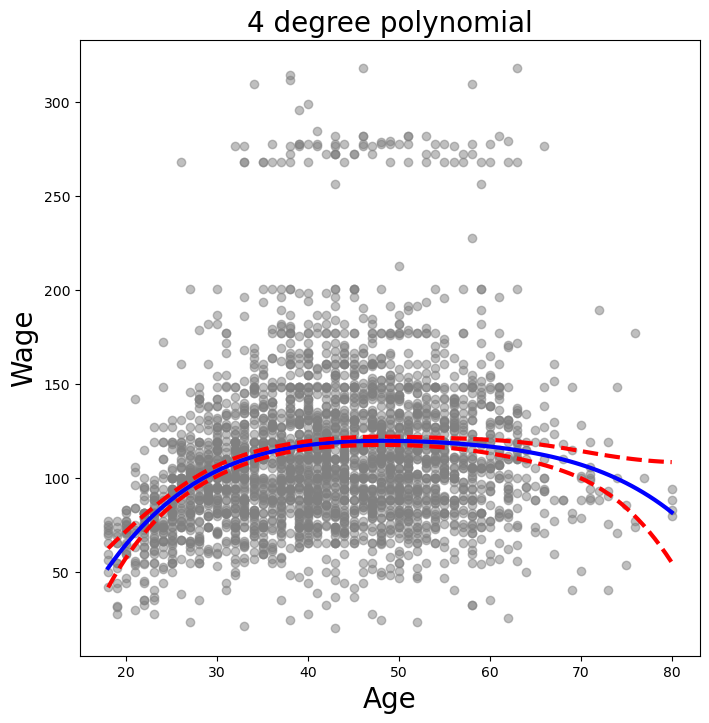

In [8]:
model4=MS([poly('age', degree=4)]).fit(Wage)
plot_wage_fit(age_df, model4, '4 degree polynomial')

In [9]:
#Perform corss validation to find the best polynomial degree
cv_error = np.zeros(6)
H = np.array(age)
M = sklearn_sm(sm.OLS)
#Let's introduce splits. We choose 5-folds cross validation for this example
cv = KFold(n_splits=5,shuffle=True,random_state=0) # The argument shuffle allows samples to overlap
for i, d in enumerate(range(1,7)):
    Xcross = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,Xcross,y,cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([1675.97797787, 1600.6843786 , 1597.00855538, 1596.20945868,
       1598.21530694, 1597.23759096])

### (b)

We'll try to compare 20 models of step functions using cross validation. 
Each of these models correponds to a different number of cutpoints.

For this we'll let the function qcut() from the pandas library automatically choose cutpoints based on quantiles. 

In [10]:
cv_error_cuts = np.zeros(20)
for i, d in enumerate(range(1,21)):
    Xcross = pd.qcut(age, d+1)
    M_CV_cut = cross_validate(M,pd.get_dummies(Xcross),y,cv=cv)
    cv_error_cuts[i] = np.mean(M_CV_cut['test_score'])
cv_error_cuts

array([1703.98624771, 1660.21747041, 1643.54893817, 1641.65415209,
       1636.90408532, 1627.35473711, 1624.53060805, 1625.31470466,
       1619.42520284, 1622.99428956, 1622.98944769, 1616.50042257,
       1613.99483953, 1617.08432164, 1617.62667623, 1620.03577132,
       1618.02476215, 1617.60926168, 1618.28838019, 1618.78656934])

The minimal CV error occurs when there are 12 cutpoints. We also could have chosen 8 cutpoints if there were less investigations.
First, we must fit the model as the function previously defined does not take into account the modified data frame coming from splitting the age feature.

In [11]:
n_groups=12
cut_age = pd.qcut(age, n_groups+1)
# Get dummy features relatively to age groups
dummy_age=pd.get_dummies(cut_age)

In [12]:
#Create a new data frame to fit the new model
df_step=dummy_age.join(y)
# Assign roles to each of the columns of the new data set and ft the model
Xnew=df_step.iloc[:,:-1]
ynew=df_step.iloc[:,-1]
ynewnp=np.array(ynew)[:,np.newaxis]
model_step=MS(Xnew,intercept=False).fit(df_step)
X=model_step.transform(df_step)
res=sm.OLS(ynewnp,X).fit()
X.shape

(3000, 13)

In [13]:
#Define a gird over which we can plot predictions. Since the ages start from 18 and end at 80
# we choose to define a grid of integer numbers through this interval
X_grid=np.linspace(18,80)
#Now let's cut the defined grid over the predifined groups. We use the cut function to create an
# ordered set of values
groups = pd.cut(X_grid, n_groups+1)
dummies = pd.get_dummies(groups)
dummies.shape

(50, 13)

Text(0, 0.5, 'Wage')

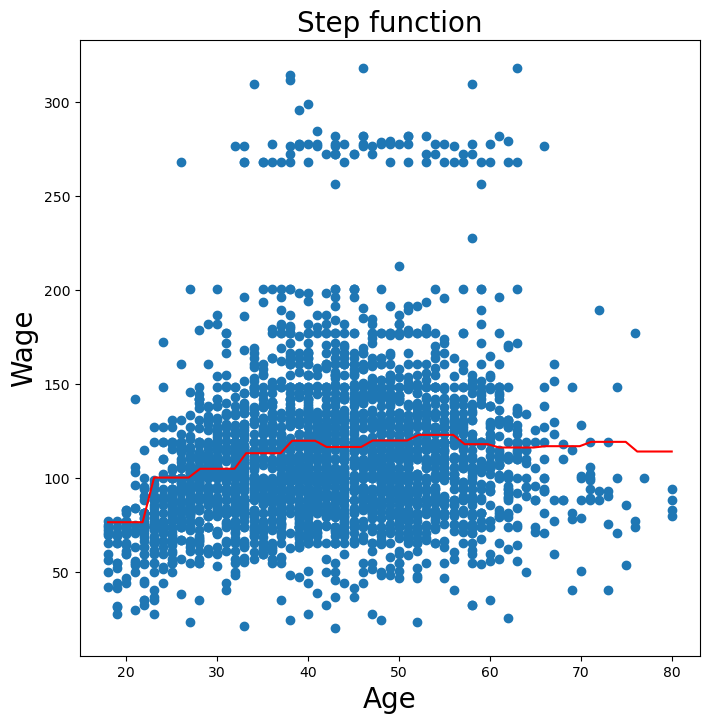

In [14]:
# Plot the function 
X_step = np.linspace(18,80)
y_step = res.predict(dummies)
fig, ax = subplots(figsize=(8,8))
plt.scatter(age,y)
plt.plot(X_step, y_step,'-r')
ax.set_title('Step function', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20)

## Exercise 7

In [15]:
Wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        3000 non-null   int64   
 1   age         3000 non-null   int64   
 2   maritl      3000 non-null   object  
 3   race        3000 non-null   object  
 4   education   3000 non-null   category
 5   region      3000 non-null   object  
 6   jobclass    3000 non-null   object  
 7   health      3000 non-null   object  
 8   health_ins  3000 non-null   object  
 9   logwage     3000 non-null   float64 
 10  wage        3000 non-null   float64 
dtypes: category(1), float64(2), int64(2), object(6)
memory usage: 237.6+ KB


In [16]:
# Convert both 'maritl' and 'joblcass' columns to categorical data
Wage['maritl']=Wage['maritl'].astype('category')
Wage['jobclass']=Wage['jobclass'].astype('category')

In [17]:
Wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        3000 non-null   int64   
 1   age         3000 non-null   int64   
 2   maritl      3000 non-null   category
 3   race        3000 non-null   object  
 4   education   3000 non-null   category
 5   region      3000 non-null   object  
 6   jobclass    3000 non-null   category
 7   health      3000 non-null   object  
 8   health_ins  3000 non-null   object  
 9   logwage     3000 non-null   float64 
 10  wage        3000 non-null   float64 
dtypes: category(3), float64(2), int64(2), object(4)
memory usage: 197.0+ KB


As the Wage data set contains 3000 observations, it is preferable to use distribution plots. We'll choose to draw boxplots then to discover the relationships among 'wage' feature and both 'maritl' and 'jobclass'.

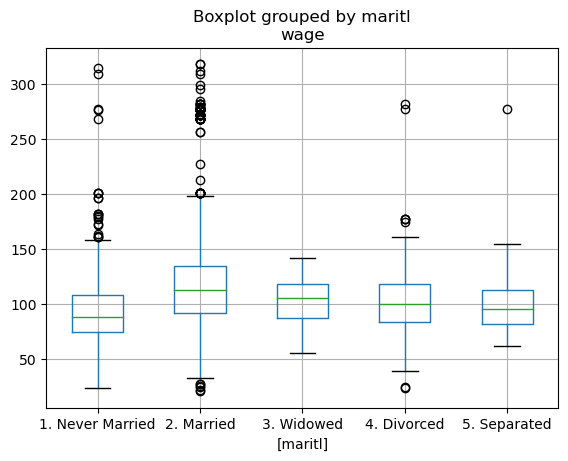

In [18]:
Wage.boxplot(column=['wage'],by=['maritl']);

It seems from observing the medians that wage is highet for married people.

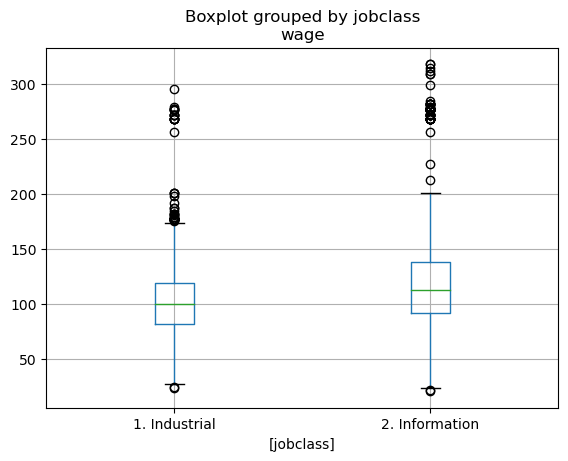

In [19]:
Wage.boxplot(column=['wage'],by=['jobclass']);

Information jobs are better paid than industrial ones.

Now we should explore models with and without those categorical features along with age feature through GAM. We can compare models using ANOVA_GAM.

In [20]:
# Compare three models: first model is the full model cause it contains all the three features
# second model contains age and maritl features
# third model contains age and jobclass features

# Let's fit the first model
gam_full = LinearGAM(s_gam(0) + f_gam(1, lam=0) +f_gam(2, lam=0))# lam=0 to avoid shrinkage for categ terms
Xgam = np.column_stack([age, Wage['maritl'].cat.codes, Wage['jobclass'].cat.codes])
gam_full = gam_full.fit(Xgam, y)

#Fit the second model
gam_m=LinearGAM(s_gam(0) + f_gam(1, lam=0))
gam_m = gam_m.fit(Xgam, y)

#Fit the third model
gam_j=LinearGAM(s_gam(0) + f_gam(2, lam=0))
gam_j = gam_j.fit(Xgam, y)

In [21]:
#compare the models
#Switch the order of arguments in anova_gam to see the difference. Basically this enables the function
# to choose positive degrees of freedom for F test.
anova_gam(gam_j,gam_m,gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,4.583674e+06,2983.792999,NaN,NaN,NaN,NaN
1,4.631290e+06,2980.795863,-47615.678433,2.997136,-10.615260,1.000000e+00
2,4.459636e+06,2979.796157,171654.007748,0.999706,114.727839,8.824273e-10


We find a compelling result showing that the full model, gven its pvalue, is better that the other ones. 

In order to present the results, we draw the partial dependence plots for each of the features.
For that, we assume that the three studied features are independant.

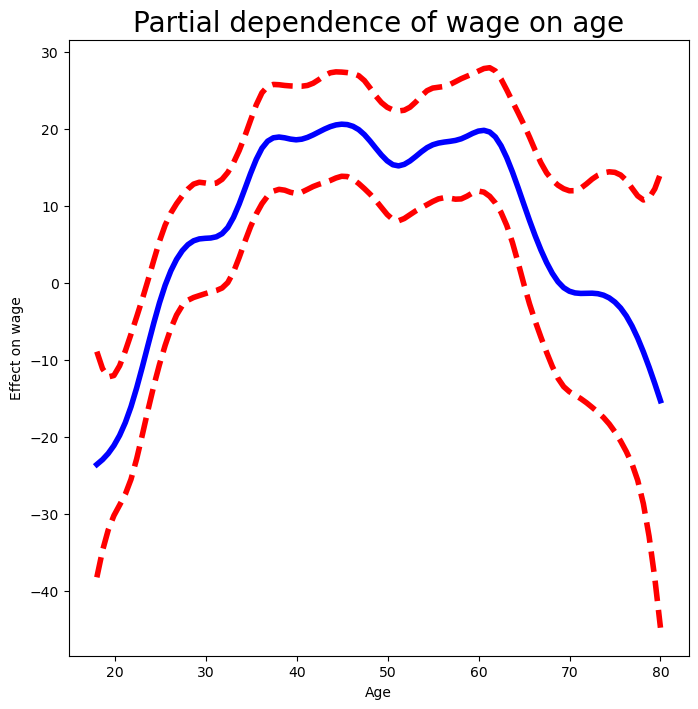

In [22]:
# Effect of age in the full model on the wage
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 0)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on age',fontsize=20);

The function is somewhat wiggly. This issue has been overcome in the lab by refitting the model along with specifiying degrees of freedom.
In either cases, the tendancy of age effect on wage will be the same. It shows that the best wage is obtained at the age between 40 and approximately 45.
A similar wage range can be seen at the age around 60.

In [23]:
#The following two lines are added because plot_gam function used thereafter does not proceed
# when the categorical data to be ploted is in the middle of the matrix model
Xgam2 = np.column_stack([age, Wage['jobclass'].cat.codes, Wage['maritl'].cat.codes])
gam_full = gam_full.fit(Xgam2, y)

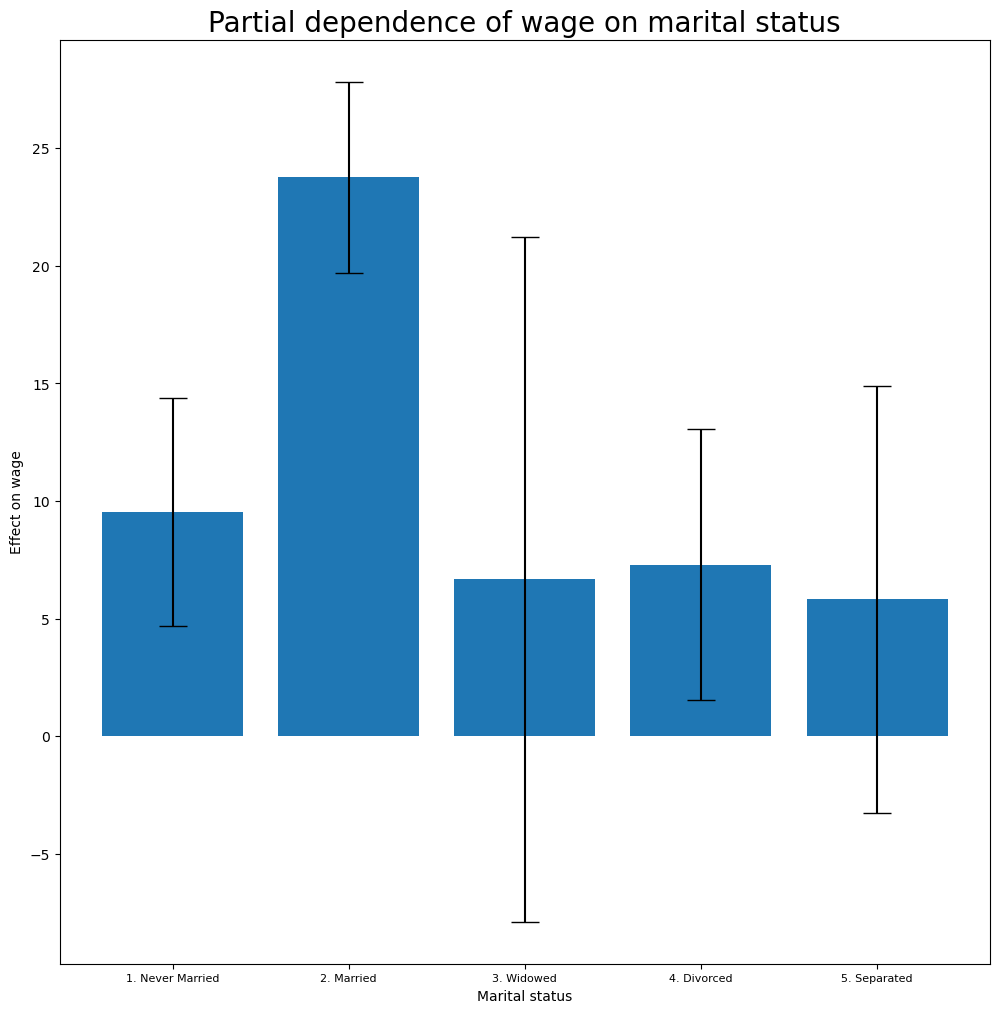

In [24]:
#Effect of maritl in the full model on the wage
fig, ax = subplots(figsize=(12, 12))
ax=plot_gam(gam_full,2)
ax.set_xlabel('Marital status')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on marital status',fontsize=20);
ax.set_xticklabels(Wage['maritl'].cat.categories, fontsize=8);

We notice that the max effect on wage is obtained when the marital status is married followed by never married category. Other categories of marital satuts seem to have a positive effect on wage too, but this effect remains low.

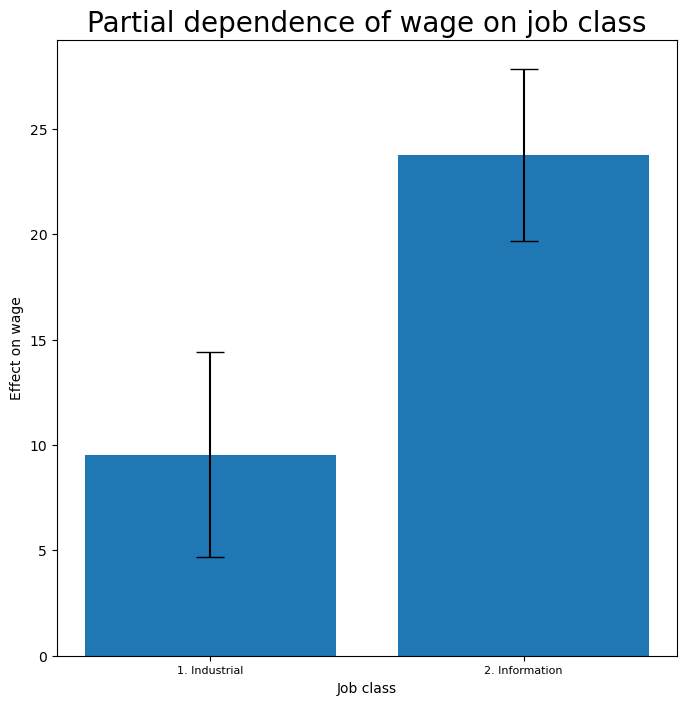

In [25]:
#Effect of jobclass in the full model on the wage
fig, ax = subplots(figsize=(8, 8))
ax=plot_gam(gam_full,1)
ax.set_xlabel('Job class')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on job class',fontsize=20);
ax.set_xticklabels(Wage['jobclass'].cat.categories, fontsize=8);

As predicted the effect of infomation jobs on wage is more important than the effect of industrial jobs.

## Exercise 8

In [26]:
Auto=load_data('Auto')
horsepower=Auto['horsepower']
mpg=Auto['mpg']

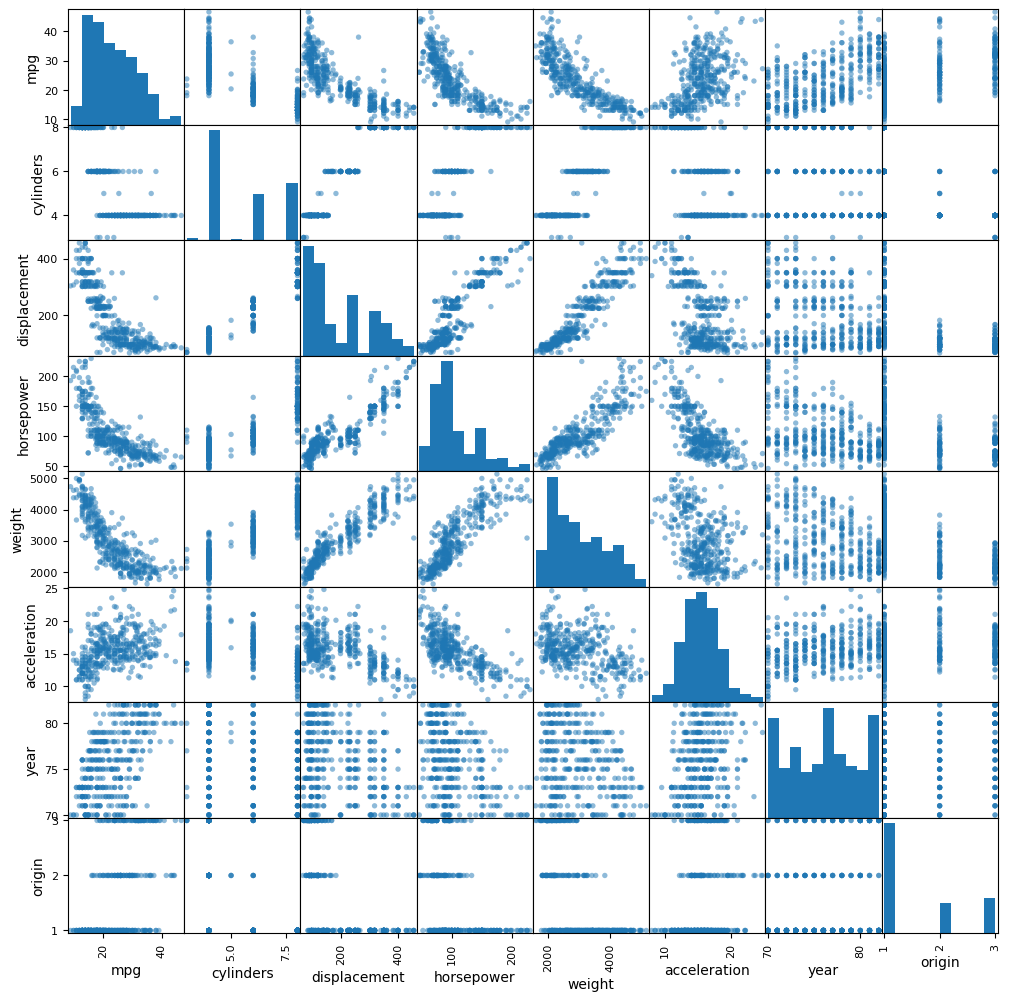

In [27]:
pd.plotting.scatter_matrix(Auto, figsize=(12,12), marker = 'o', 
                           hist_kwds = {'bins': 10}, s = 15, alpha = 0.5);

In the book we analyse the behavior of mpg depending on other features. Let's just analyze the same feature as an output.

In [28]:
Auto.corr()

C:\Users\kabousselham\AppData\Local\Temp\ipykernel_17156\340684133.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Auto.corr()


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


By looking at the correlation matrix and the previous pairplot, it is predictible that mpg has non linear relationships with cylinders, displacement, horsepower and weight.

Features seem to be highly correlated. Modelization with one predictible variable sounds a wise choice. For this we will try to regress mpg on horsepower as the previous chapters of the book did.

In [29]:
# For the polynomial regression we search the optimal degree with cross validation cv=5
cv_error = np.zeros(11)
Hm = np.array(horsepower)
M = sklearn_sm(sm.OLS)
#Let's introduce splits. 
cv = KFold(n_splits=5,shuffle=True,random_state=0)
for i, d in enumerate(range(1,12)):
    Xcrossm = np.power.outer(Hm, np.arange(d+1))
    Mat_CV = cross_validate(M,Xcrossm,mpg,cv=cv)
    cv_error[i] = np.mean(Mat_CV['test_score'])
cv_error

array([24.129309  , 19.16472771, 19.30299359, 19.44988803, 18.98092835,
       18.97455657, 18.8849115 , 22.90723236, 23.0378342 , 48.91308875,
       71.58993753])

The cross validation error is minimal where the polynomial degree equals 7.

In [30]:
# define a grid of 100 points over which we can compute model predictions 
horse_grid = np.linspace(horsepower.min(), horsepower.max(), 100)
horse_df=pd.DataFrame({'horsepower':horse_grid})

In [31]:
def plot_mpg_fit(horse_df, basis, title):
    """ Function which returns the plot of the fitted polynomial model"""
    X1 = basis.transform(Auto)
    Xnew1 = basis.transform(horse_df)
    M = sm.OLS(mpg, X1).fit()
    preds = M.get_prediction(Xnew1)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(horsepower,mpg,facecolor='gray',alpha=0.5)
    for val, ls in zip([preds.predicted_mean,bands[:,0],bands[:,1]],['b','r--','r--']):
        ax.plot(horse_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Horsepower', fontsize=20)
    ax.set_ylabel('mpg', fontsize=20);
    return ax

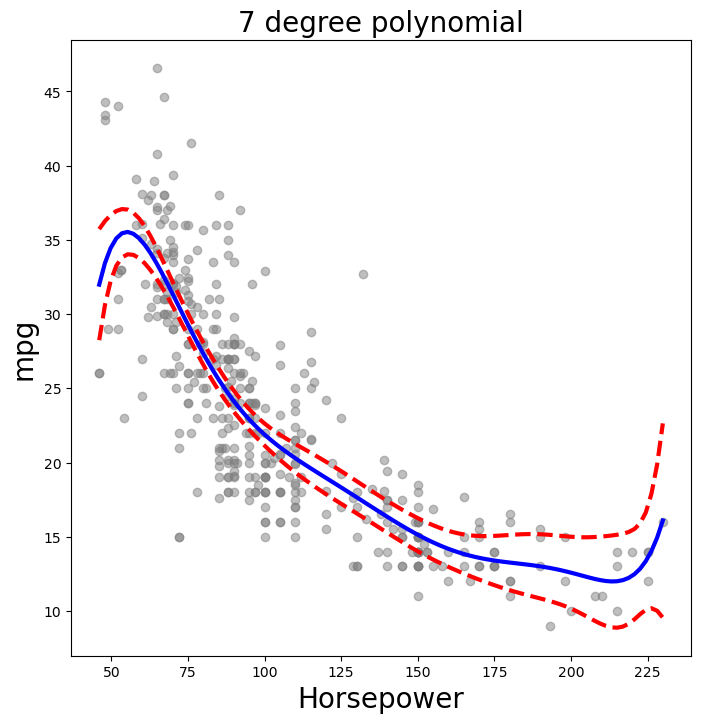

In [32]:
model7=MS([poly('horsepower', degree=7)]).fit(Auto)
plot_mpg_fit(horse_df, model7, '7 degree polynomial');

In [33]:
X1 = model7.transform(Auto)
M = sm.OLS(mpg, X1).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,23.4459,0.217,108.058,0.000
"poly(horsepower, degree=7)[0]",-120.1377,4.296,-27.966,0.000
"poly(horsepower, degree=7)[1]",44.0895,4.296,10.263,0.000
"poly(horsepower, degree=7)[2]",-3.9488,4.296,-0.919,0.359
"poly(horsepower, degree=7)[3]",-5.1878,4.296,-1.208,0.228
"poly(horsepower, degree=7)[4]",13.2722,4.296,3.089,0.002
"poly(horsepower, degree=7)[5]",-8.5462,4.296,-1.989,0.047
"poly(horsepower, degree=7)[6]",7.9806,4.296,1.858,0.064


We notice that pvalue of degree 7 is not sigificant and the graph is wiggly. This implies that the best polynomial model has 6 degrees, which means that we have to refit the model using the same approach as above.

In [34]:
# Step function model. First, let's try to find the optimal number of cuts
#We'll use for that cross validation approach
cv_error_cuts = np.zeros(20)
for i, d in enumerate(range(1,21)):
    Xcross = pd.qcut(horsepower, d+1)
    M_CV_cut = cross_validate(sklearn_sm(sm.OLS),pd.get_dummies(Xcross),mpg,cv=cv)
    cv_error_cuts[i] = np.mean(M_CV_cut['test_score'])
cv_error_cuts

array([29.82444399, 23.41049429, 20.26054905, 20.94466903, 18.9431238 ,
       19.74372876, 18.83251652, 18.69517885, 19.38914021, 18.70211447,
       17.9802214 , 19.46457473, 19.12644741, 19.03149541, 18.25730498,
       19.42660673, 19.07914753, 19.26482791, 18.92616421, 20.80317346])

We deduce from the minimum cross validation error that the best number of cuts is 10.

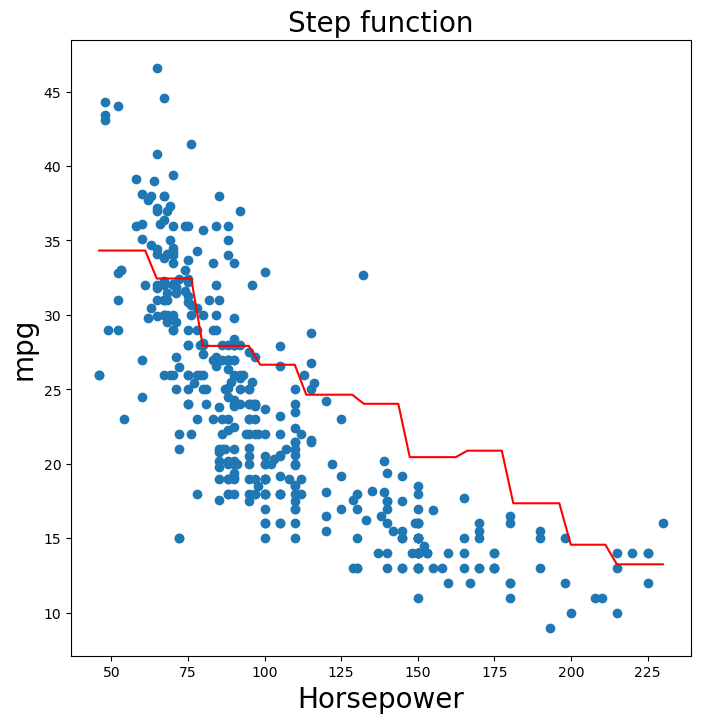

In [35]:
n_cuts=10
cut_horse = pd.qcut(horsepower, n_cuts+1)
# Get dummy features relatively to horsepower groups
dummy_horse=pd.get_dummies(cut_horse)
#Create a new data frame to fit the new model
dfh_step=dummy_horse.join(mpg)
# Assign roles to each of the columns of the new data set and ft the model
Xnewh=dfh_step.iloc[:,:-1]
ynewh=dfh_step.iloc[:,-1]
ynewhnp=np.array(ynewh)[:,np.newaxis]
modelh_step=MS(Xnewh,intercept=False).fit(dfh_step)
Xh=modelh_step.transform(dfh_step)
resh=sm.OLS(ynewhnp,Xh).fit()
#Define a gird over which we can plot predictions
Xh_grid=np.linspace(horsepower.min(),horsepower.max())
#Now let's cut the defined grid over the predifined groups. We use the cut function to create an
# ordered set of values
groupsh = pd.cut(Xh_grid, n_cuts+1)
dummiesh = pd.get_dummies(groupsh)
# Plot the step function 
yh_step = resh.predict(dummiesh)
fig, ax = subplots(figsize=(8,8))
plt.scatter(horsepower,mpg)
plt.plot(Xh_grid, yh_step,'-r')
ax.set_title('Step function', fontsize=20)
ax.set_xlabel('Horsepower', fontsize=20)
ax.set_ylabel('mpg', fontsize=20);

In [36]:
summarize(resh)

,coef,std err,t,P>|t|
"(45.999, 65.0]",34.3243,0.701,48.982,0.0
"(65.0, 71.0]",32.4462,0.683,47.537,0.0
"(71.0, 78.0]",27.9235,0.731,38.198,0.0
"(78.0, 86.0]",26.6583,0.710,37.525,0.0
"(86.0, 90.0]",24.6452,0.658,37.471,0.0
"(90.0, 96.273]",24.0346,0.836,28.751,0.0
"(96.273, 105.0]",20.4524,0.658,31.096,0.0
"(105.0, 115.364]",20.8862,0.792,26.387,0.0
"(115.364, 145.0]",17.3553,0.691,25.099,0.0
"(145.0, 165.0]",14.5722,0.710,20.512,0.0


Obviously the step function looks wiggly. The polynomial regression seems to fit better the training model. 

In [37]:
#Natural cubic spline model. We could have used cross validation to determine the degrees of freedom.
# But we assume here, as it is often the case, that there must be 6 since a cubic spline implies 
# 4 degrees along with 2 more constraints to add at the ends.
ns_horse = MS([ns('horsepower', df=6)]).fit(Auto)
M_nsh = sm.OLS(mpg, ns_horse.transform(Auto)).fit()
summarize(M_nsh)

,coef,std err,t,P>|t|
intercept,34.7379,1.509,23.021,0.0
"ns(horsepower, df=6)[0]",-8.2104,1.594,-5.149,0.0
"ns(horsepower, df=6)[1]",-13.0459,1.835,-7.108,0.0
"ns(horsepower, df=6)[2]",-14.5766,1.886,-7.730,0.0
"ns(horsepower, df=6)[3]",-22.8020,1.624,-14.039,0.0
"ns(horsepower, df=6)[4]",-22.7577,3.512,-6.480,0.0
"ns(horsepower, df=6)[5]",-20.8492,1.742,-11.967,0.0


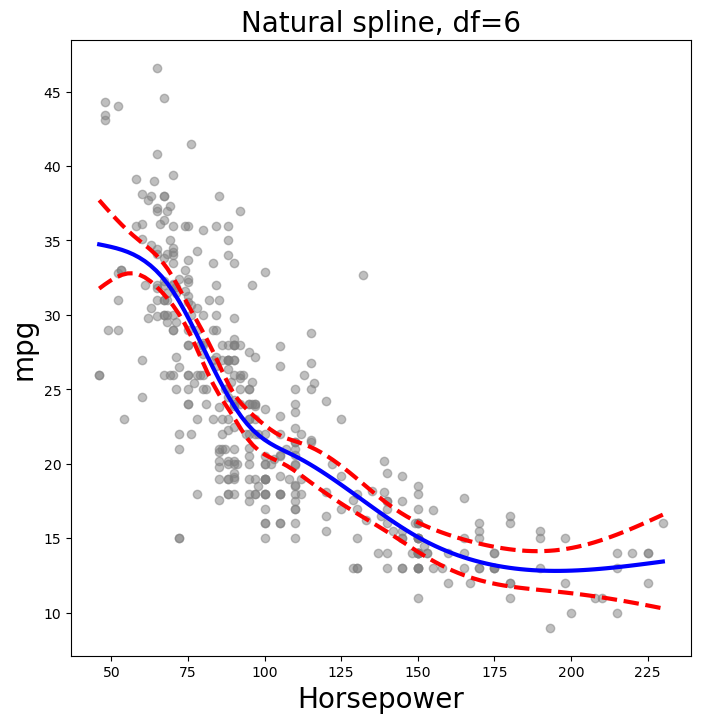

In [38]:
plot_mpg_fit(horse_df, ns_horse,'Natural spline, df=6');

All the coefficients are significant and the confidence intervals plots at the ends look stable.

## Exercise 9

In [39]:
Boston=load_data('Boston')
dis=Boston['dis']
nox=Boston['nox']

### (a)

In [40]:
model3=MS([poly('dis', degree=3)]).fit(Boston)
X=model3.transform(Boston)
res=sm.OLS(nox, X).fit()

In [41]:
summarize(res)

,coef,std err,t,P>|t|
intercept,0.5547,0.003,201.021,0.0
"poly(dis, degree=3)[0]",-2.0031,0.062,-32.271,0.0
"poly(dis, degree=3)[1]",0.8563,0.062,13.796,0.0
"poly(dis, degree=3)[2]",-0.3180,0.062,-5.124,0.0


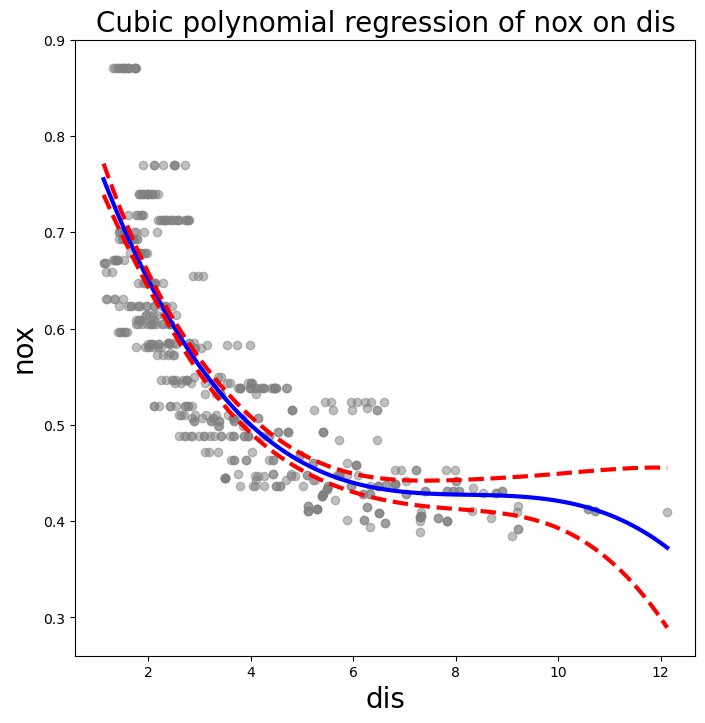

In [42]:
#Define the grid of predictor values
dis_grid = np.linspace(dis.min(), dis.max(), 100)
dis_df=pd.DataFrame({'dis':dis_grid})
dis2_df=pd.DataFrame({'dis':dis})
#Plot the results
Xnew2=model3.transform(dis_df)
preds = res.get_prediction(Xnew2)
bands = preds.conf_int(alpha=0.05)
fig, ax = subplots(figsize=(8,8))
ax.scatter(dis,nox,facecolor='gray',alpha=0.5)
for val, ls in zip([preds.predicted_mean,bands[:,0],bands[:,1]],['b','r--','r--']):
        ax.plot(dis_df.values, val, ls, linewidth=3)
ax.set_title('Cubic polynomial regression of nox on dis', fontsize=20)
ax.set_xlabel('dis', fontsize=20)
ax.set_ylabel('nox', fontsize=20);

In [43]:
preds=preds.predicted_mean.reshape(-1,1)
preds.shape

(100, 1)

### (b)

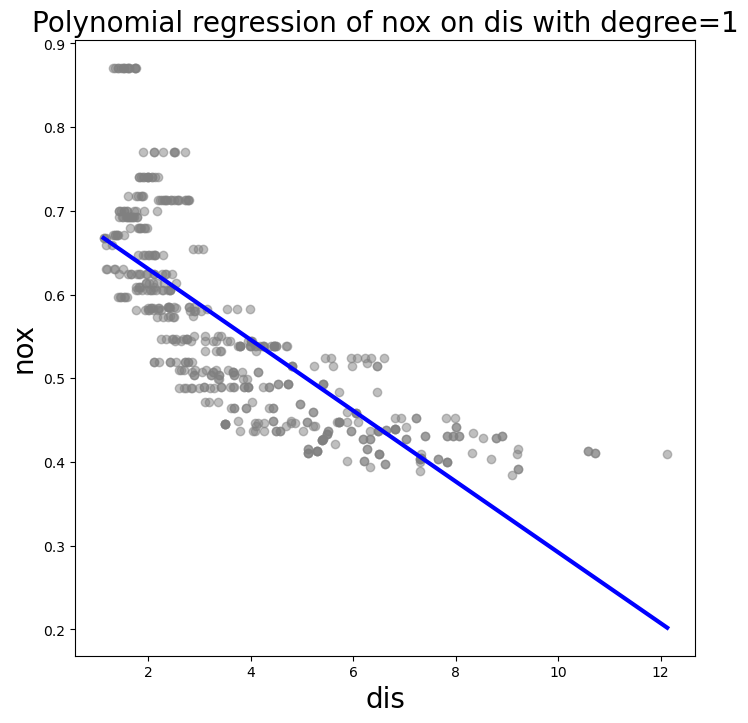

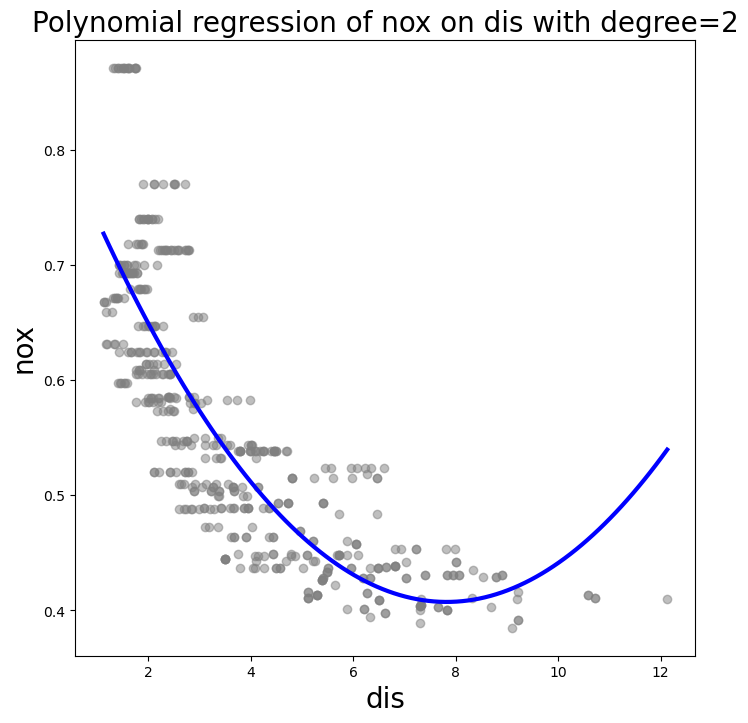

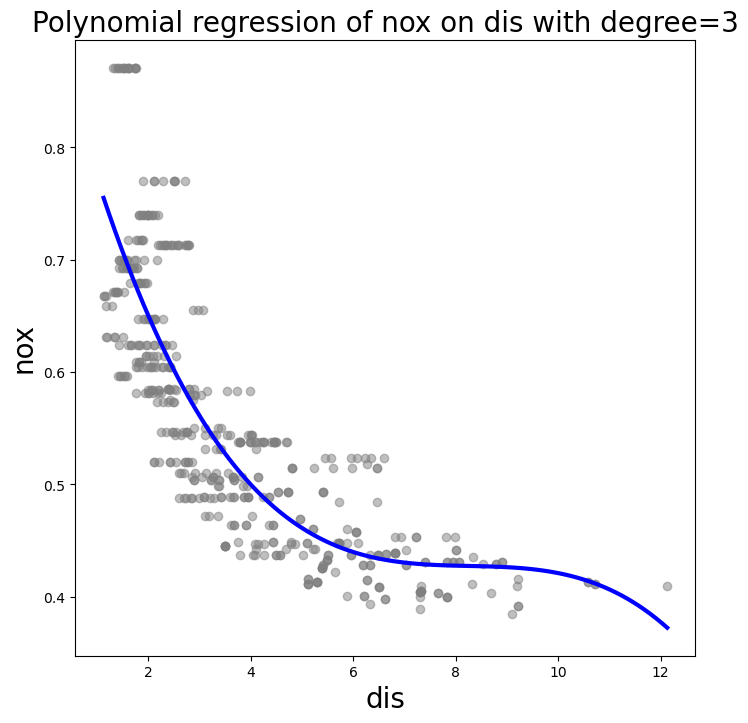

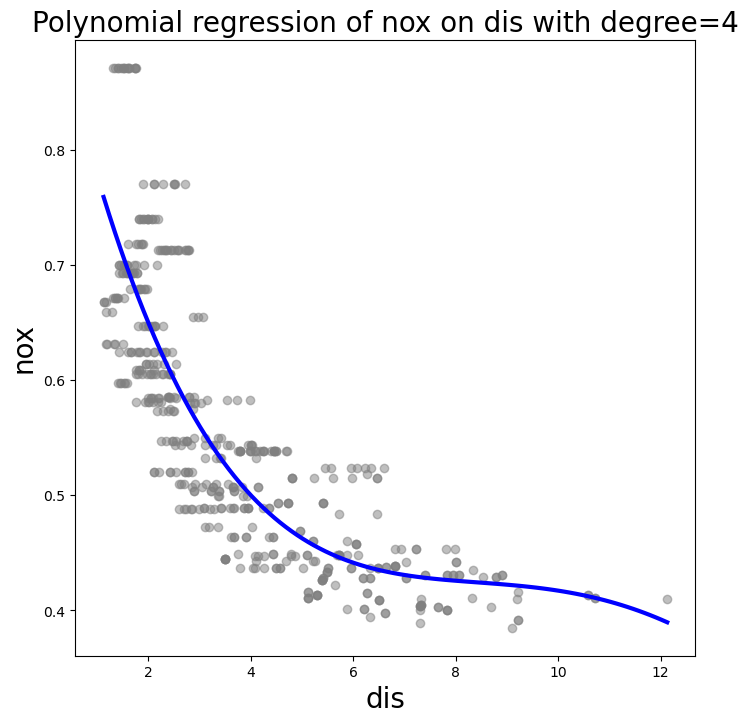

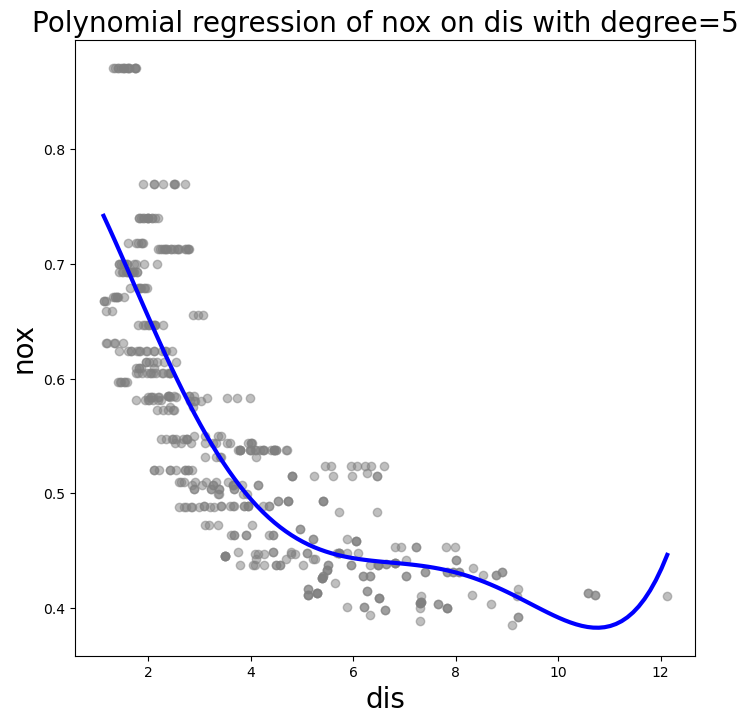

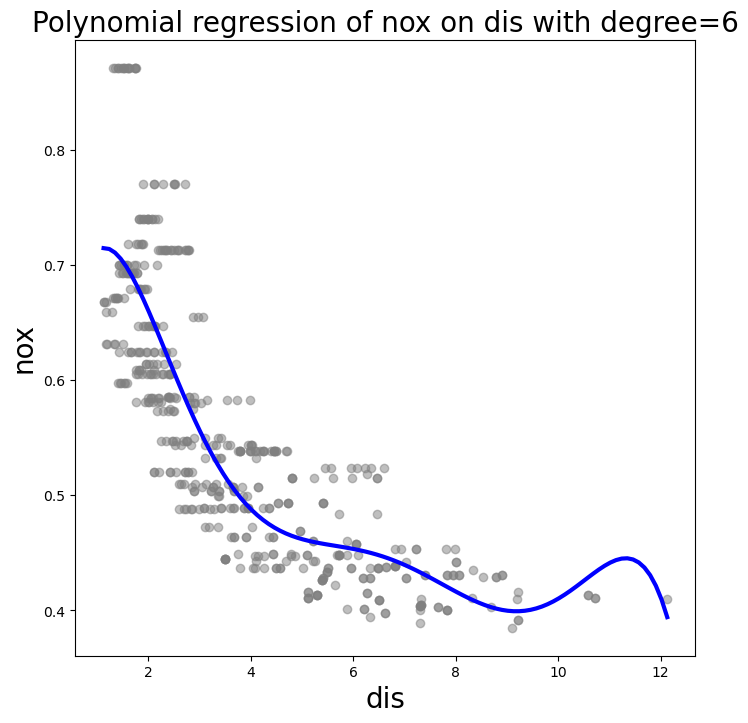

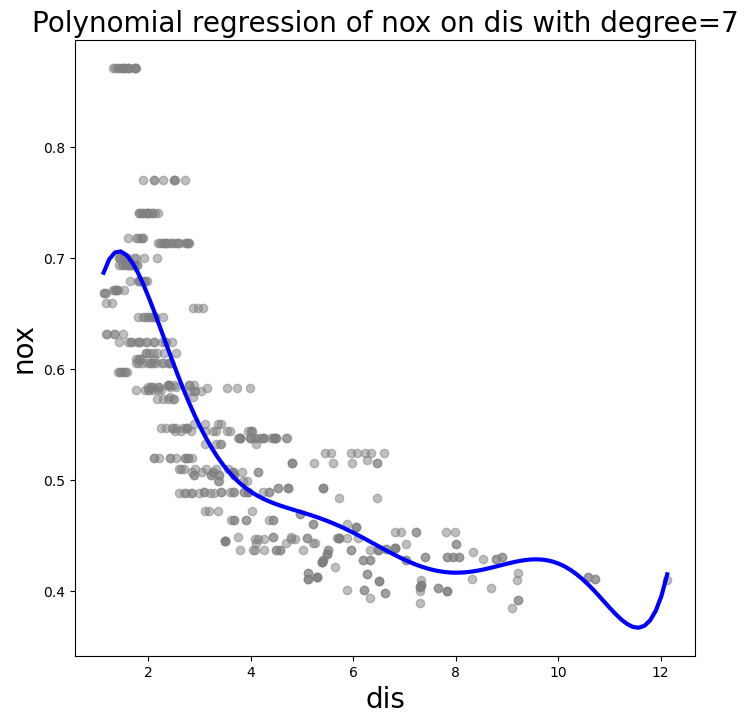

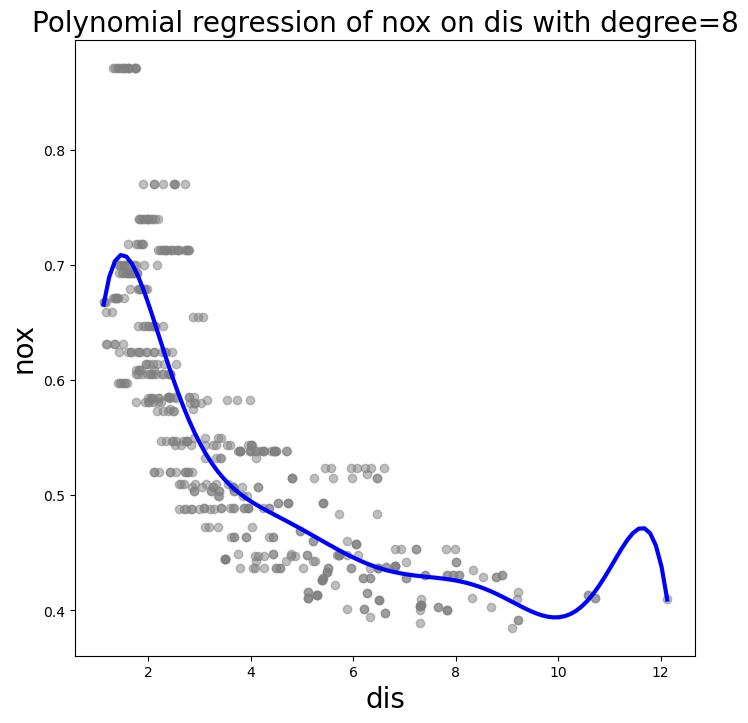

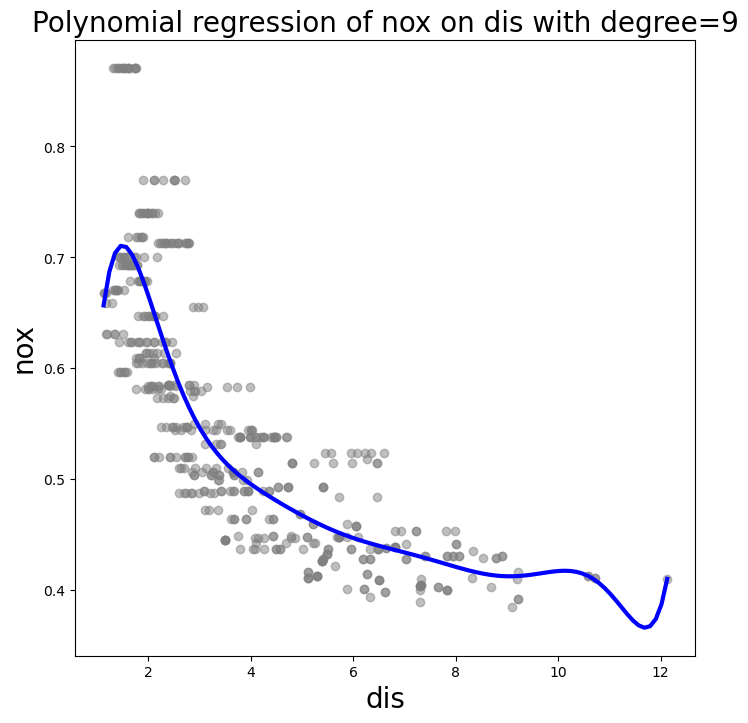

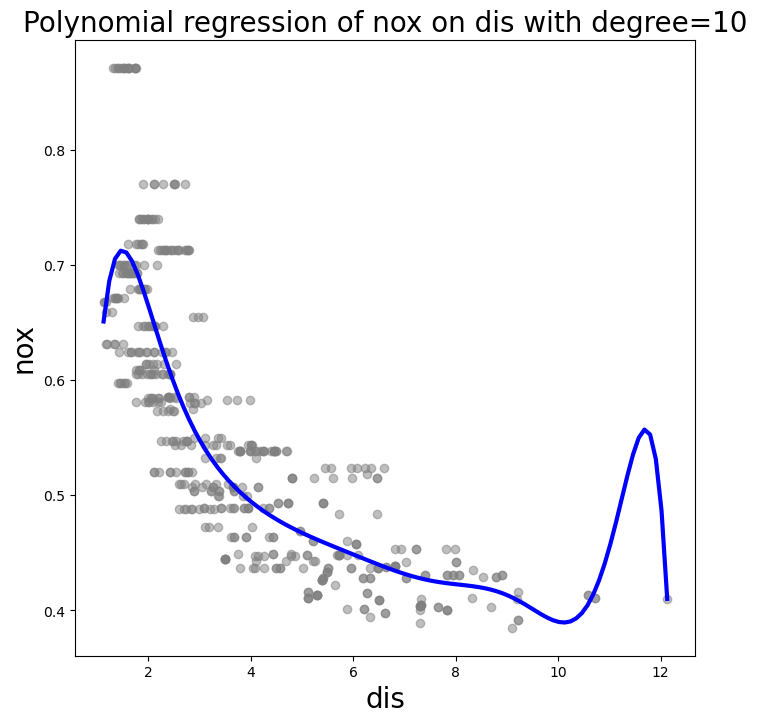

In [44]:
RSS={}
for d in range(1,11):
    model=MS([poly('dis', degree=d)]).fit(Boston)
    X=model.transform(Boston)
    res=sm.OLS(nox, X).fit()
    Xnew=model.transform(dis_df)
    Xnew2=model.transform(dis2_df)
    preds = res.get_prediction(Xnew)
    yhat=res.get_prediction(Xnew2)
    yhat=yhat.predicted_mean
    RSS[d]=np.sum((nox - yhat)**2)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(dis,nox,facecolor='gray',alpha=0.5)
    ax.plot(dis_df.values,preds.predicted_mean , 'b', linewidth=3)
    ax.set_title('Polynomial regression of nox on dis with degree='+ str(d), fontsize=20)
    ax.set_xlabel('dis', fontsize=20)
    ax.set_ylabel('nox', fontsize=20);


In [45]:
pd.DataFrame(RSS,index = ['RSS']).T

,RSS
1,2.768563
2,2.035262
3,1.934107
4,1.932981
5,1.915290
6,1.878257
7,1.849484
8,1.835630
9,1.833331
10,1.832171


As expected, the training RSE decreases with the polynomial degree.

### (c)

In [46]:
# Using cross validation to find the best polynomial degree. cv=5
cv_error = np.zeros(11)
H = np.array(dis)
M = sklearn_sm(sm.OLS)
#Let's introduce splits. 
cv = KFold(n_splits=5,shuffle=True,random_state=0)
for i, d in enumerate(range(1,12)):
    Xcross = np.power.outer(H, np.arange(d+1))
    Mat_CV = cross_validate(M,Xcross,nox,cv=cv)
    cv_error[i] = np.mean(Mat_CV['test_score'])
cv_error

array([0.00550455, 0.00404589, 0.00384482, 0.00385288, 0.00405327,
       0.00490166, 0.00711742, 0.0065405 , 0.02188365, 0.00468503,
       0.05257704])

The optimal polynomial regression is obtained for 3 degrees.

### (d)

In [47]:
bs_dis = MS([bs('dis', df=4)]).fit(Boston)
M_bs = sm.OLS(nox, bs_dis.transform(Boston)).fit()
summarize(M_bs)

,coef,std err,t,P>|t|
intercept,0.7345,0.015,50.306,0.000
"bs(dis, df=4)[0]",-0.0581,0.022,-2.658,0.008
"bs(dis, df=4)[1]",-0.4636,0.024,-19.596,0.000
"bs(dis, df=4)[2]",-0.1998,0.043,-4.634,0.000
"bs(dis, df=4)[3]",-0.3888,0.046,-8.544,0.000


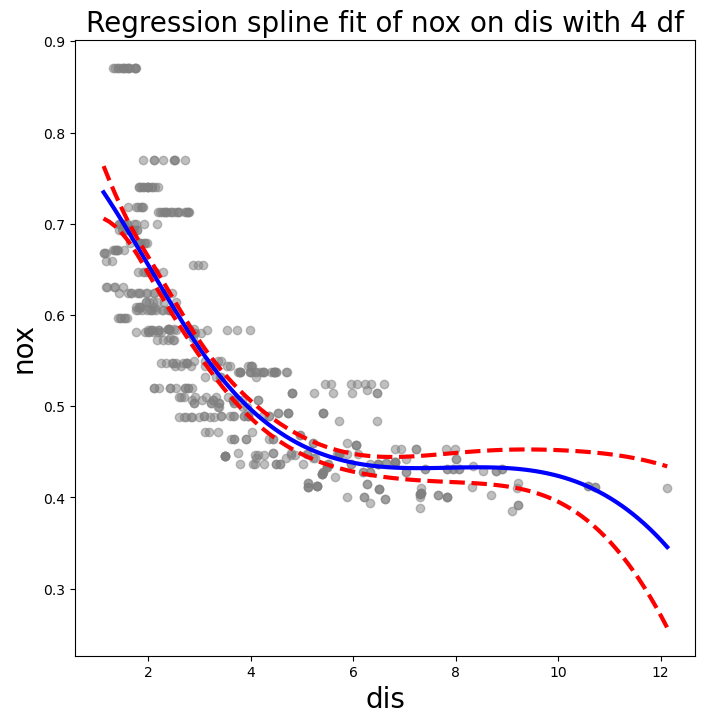

In [48]:
X = bs_dis.transform(Boston)
Xnew = bs_dis.transform(dis_df)
M = sm.OLS(nox, X).fit()
preds = M.get_prediction(Xnew)
bands = preds.conf_int(alpha=0.05)
fig, ax = subplots(figsize=(8,8))
ax.scatter(dis,nox,facecolor='gray',alpha=0.5)
for val, ls in zip([preds.predicted_mean,bands[:,0],bands[:,1]],['b','r--','r--']):
        ax.plot(dis_df.values, val, ls, linewidth=3)
ax.set_title('Regression spline fit of nox on dis with 4 df', fontsize=20)
ax.set_xlabel('dis', fontsize=20)
ax.set_ylabel('nox', fontsize=20);

The knots were automatically chosen as the four quartiles.

### (e)

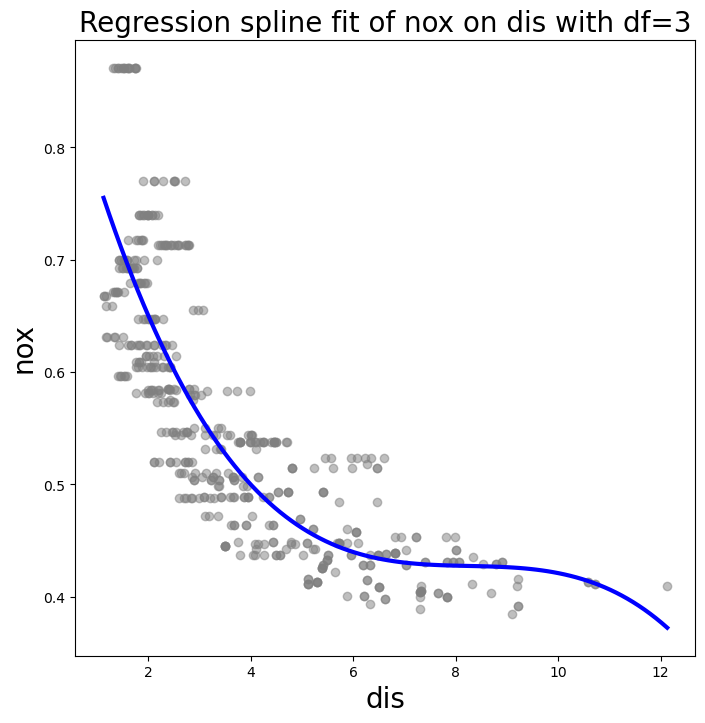

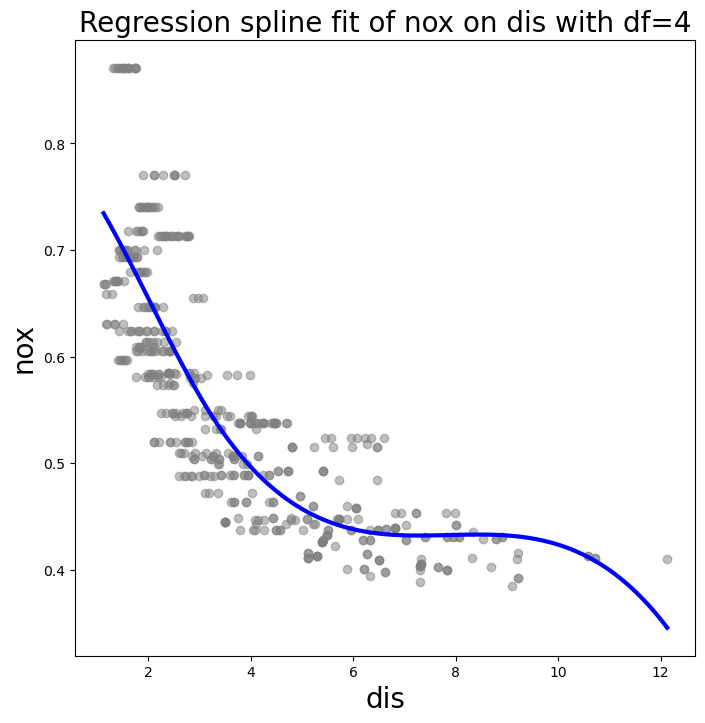

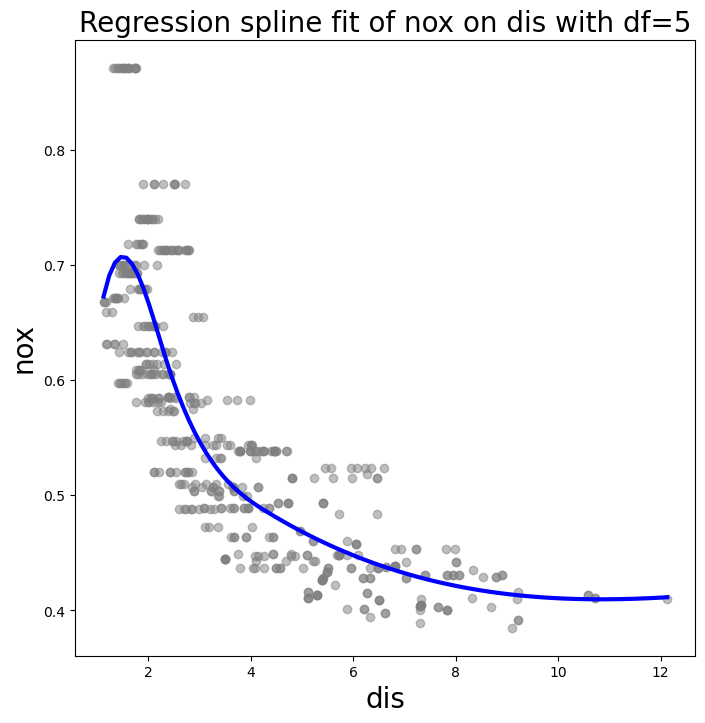

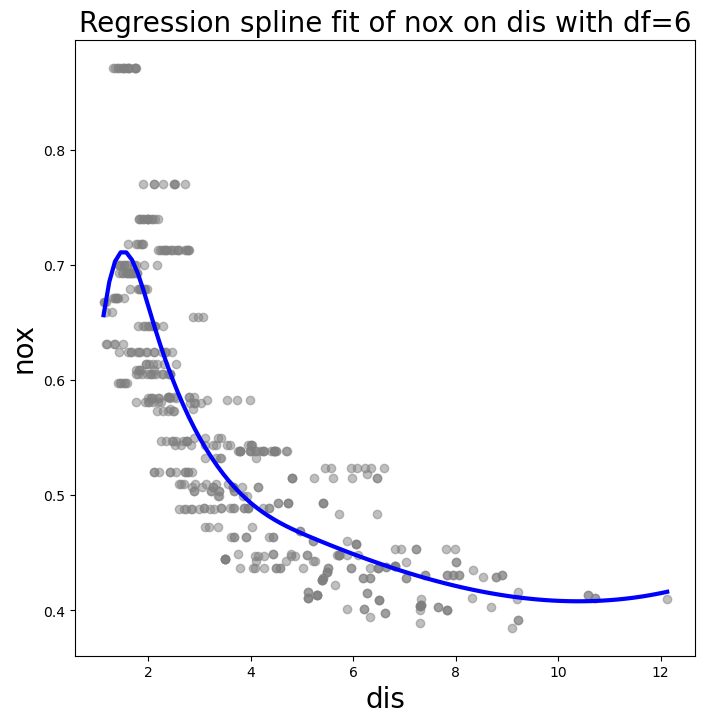

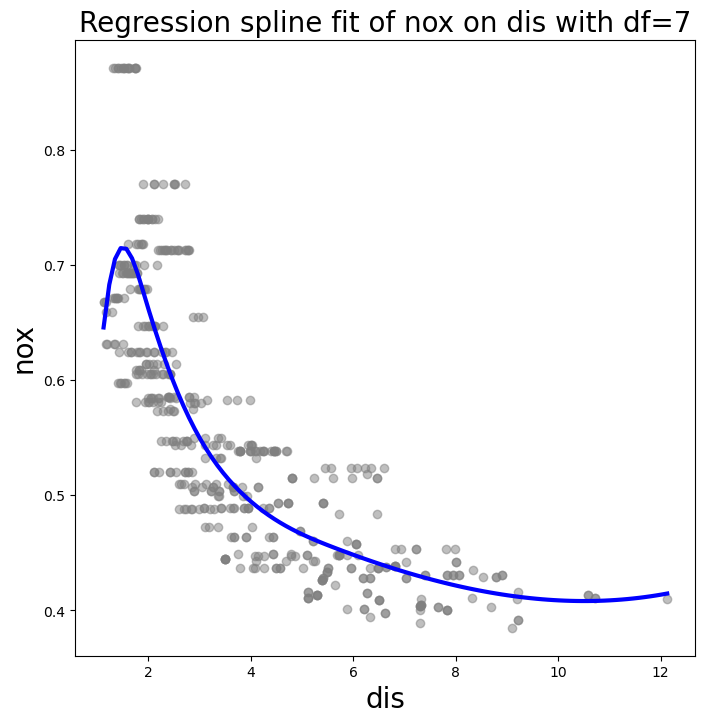

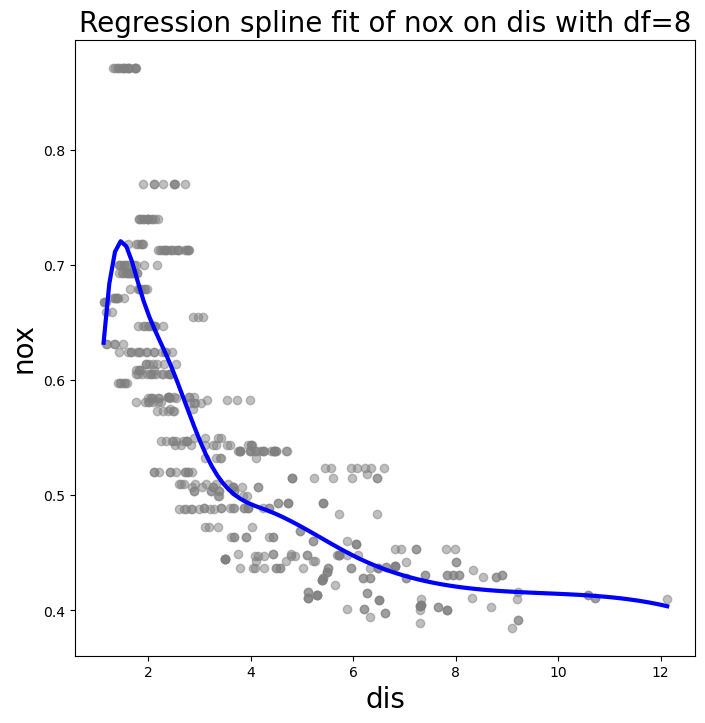

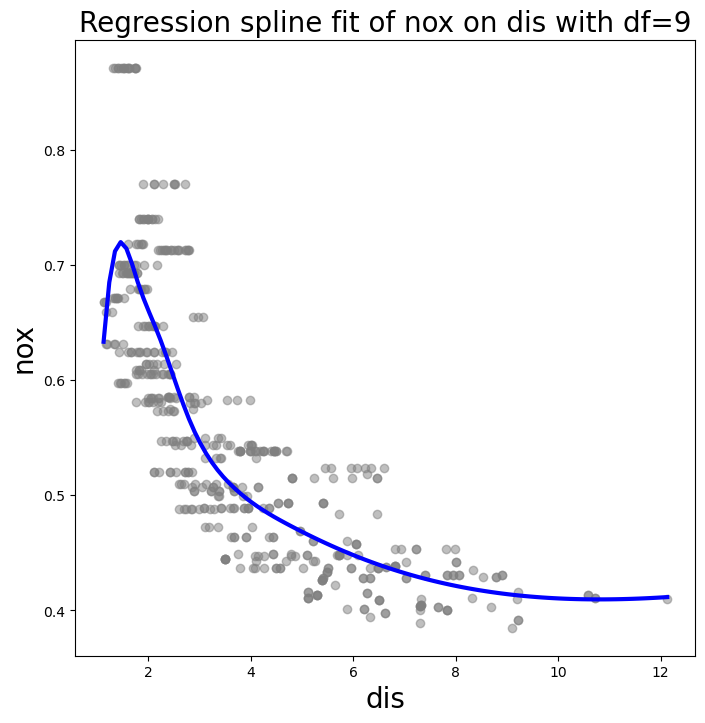

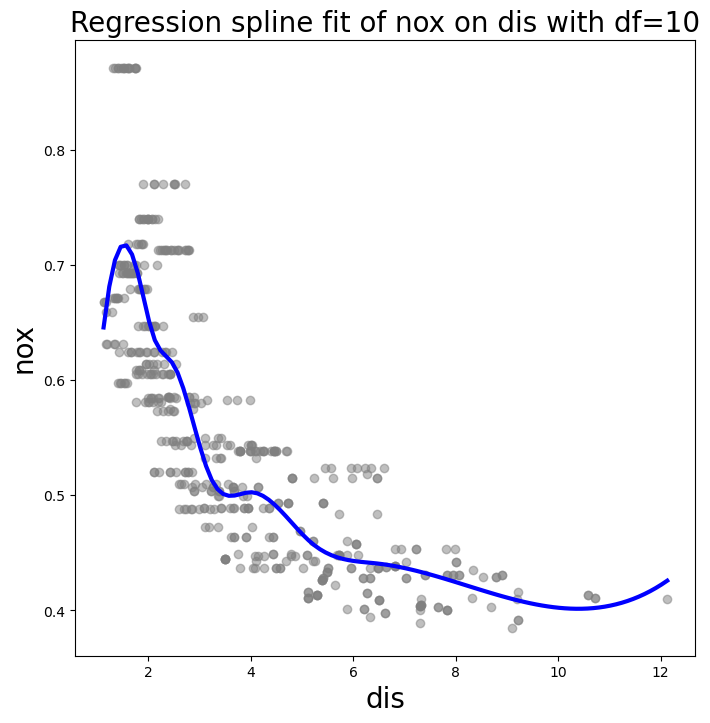

In [49]:
RSS={}
for d in range(3,11):
    bs_dis = MS([bs('dis', df=d)]).fit(Boston)
    M_bs = sm.OLS(nox, bs_dis.transform(Boston)).fit()
    Xnew = bs_dis.transform(dis_df)
    Xnew2=bs_dis.transform(dis2_df)
    preds = M_bs.get_prediction(Xnew)
    yhat=M_bs.get_prediction(Xnew2)
    yhat=yhat.predicted_mean
    RSS[d]=np.sum((nox - yhat)**2)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = subplots(figsize=(8,8))
    ax.scatter(dis,nox,facecolor='gray',alpha=0.5)
    ax.plot(dis_df.values, preds.predicted_mean, 'b', linewidth=3)
    ax.set_title('Regression spline fit of nox on dis with df='+str(d), fontsize=20)
    ax.set_xlabel('dis', fontsize=20)
    ax.set_ylabel('nox', fontsize=20);

In [50]:
pd.DataFrame(RSS,index = ['RSS']).T

,RSS
3,1.934107
4,1.922775
5,1.840173
6,1.833966
7,1.829884
8,1.816995
9,1.825653
10,1.792535


The training RSS decreases with degrees of freedom. We cannot decide which is the best regression spline model.

### (f)

In [51]:
# Using cross validation to find the best regression spline model. cv=10
cv_error = np.zeros(9)
M = sklearn_sm(sm.OLS)
cv = KFold(n_splits=10,shuffle=True,random_state=1)
for d in range(3,12):
    bs_dis = MS([bs('dis', df=d)]).fit(Boston)
    Xcross = bs_dis.transform(Boston)
    Mat_CV = cross_validate(M,Xcross,nox,cv=cv)
    cv_error[d-3] = np.mean(Mat_CV['test_score'])
cv_error

array([0.00387002, 0.00388453, 0.0037093 , 0.0037177 , 0.00372454,
       0.00371579, 0.00375893, 0.00371381, 0.00373558])

The optimal model is obtained for 5 degrees of freedom but results seem unstable. Another approach like ANOVA can be more useful to spot the best model.

## Exercise 10

In [52]:
College=load_data('College')

### (a)

In [53]:
College_train, College_valid = train_test_split(College, test_size=0.5, random_state=0)

In [54]:
College['Private']=College['Private'].astype('category')
College_train['Private']=College_train['Private'].astype('category')
College_valid['Private']=College_valid['Private'].astype('category')
y=College_train['Outstate']
Vars_train = College_train.columns.drop(['Outstate'])
design=MS(Vars_train).fit(College_train)
X_train=design.transform(College_train)
College_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 54 to 684
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Private      388 non-null    category
 1   Apps         388 non-null    int64   
 2   Accept       388 non-null    int64   
 3   Enroll       388 non-null    int64   
 4   Top10perc    388 non-null    int64   
 5   Top25perc    388 non-null    int64   
 6   F.Undergrad  388 non-null    int64   
 7   P.Undergrad  388 non-null    int64   
 8   Outstate     388 non-null    int64   
 9   Room.Board   388 non-null    int64   
 10  Books        388 non-null    int64   
 11  Personal     388 non-null    int64   
 12  PhD          388 non-null    int64   
 13  Terminal     388 non-null    int64   
 14  S.F.Ratio    388 non-null    float64 
 15  perc.alumni  388 non-null    int64   
 16  Expend       388 non-null    int64   
 17  Grad.Rate    388 non-null    int64   
dtypes: category(1), float64(1), i

In [55]:
# Define the scoring system based on Cp coefficient
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 
design_sigma = MS(College.columns.drop('Outstate')).fit(College)
Y_sigma = np.array(College['Outstate'])
X_sigma = design_sigma.transform(College)
sigma2 = OLS(Y_sigma,X_sigma).fit().scale
neg_Cp = partial(nCp, sigma2)

In [56]:
strategy=Stepwise.first_peak(design,direction='forward',max_terms=len(design.terms))
Outstate_MSE = sklearn_selected(OLS,strategy,scoring=neg_Cp)
Outstate_MSE.fit(College_train, y)
Outstate_MSE.selected_state_

('Accept',
 'Expend',
 'F.Undergrad',
 'Grad.Rate',
 'Personal',
 'Private',
 'Room.Board',
 'Terminal',
 'Top10perc',
 'perc.alumni')

The optimization of Cp coefficient shows that the best model obtained by forward stepwise selection relies on 10 predictors.

### (b)

In [57]:
gam = LinearGAM(s_gam(0)+ s_gam(1)+s_gam(2)+s_gam(3)+s_gam(4)+ f_gam(5, lam=0) 
                +s_gam(6)+s_gam(7)+s_gam(8)+s_gam(9))
Xgam = np.column_stack([College_train['Accept'],College_train['Expend'],College_train['F.Undergrad'],College_train['Grad.Rate'],
                        College_train['Personal'], College_train['Private'].cat.codes,College_train['Room.Board'],
                        College_train['Terminal'],College_train['Top10perc'],College_train['perc.alumni']])
gam = gam.fit(Xgam, y)

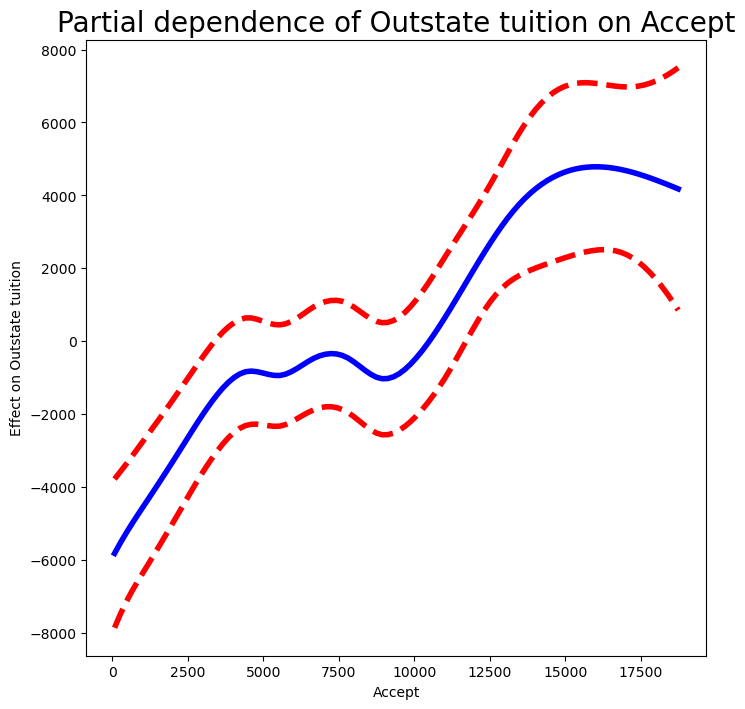

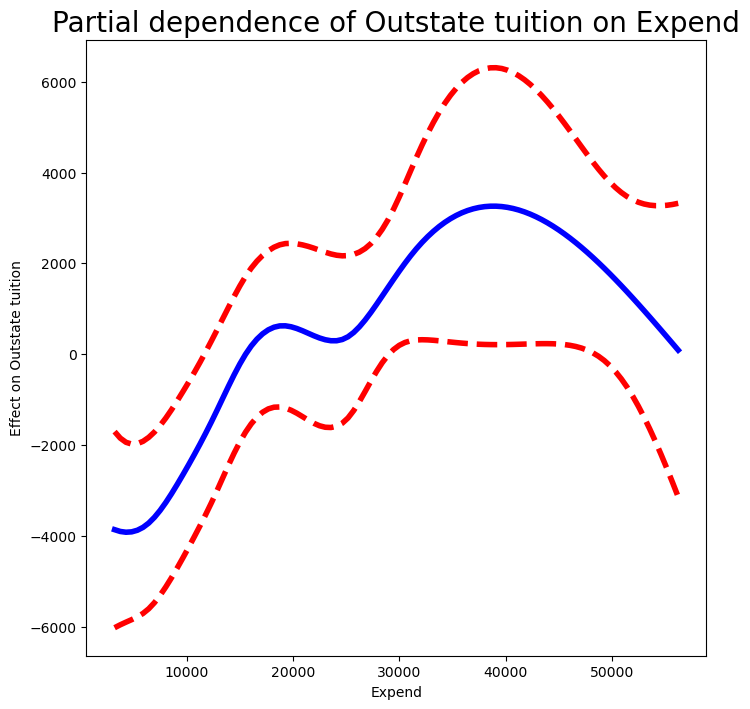

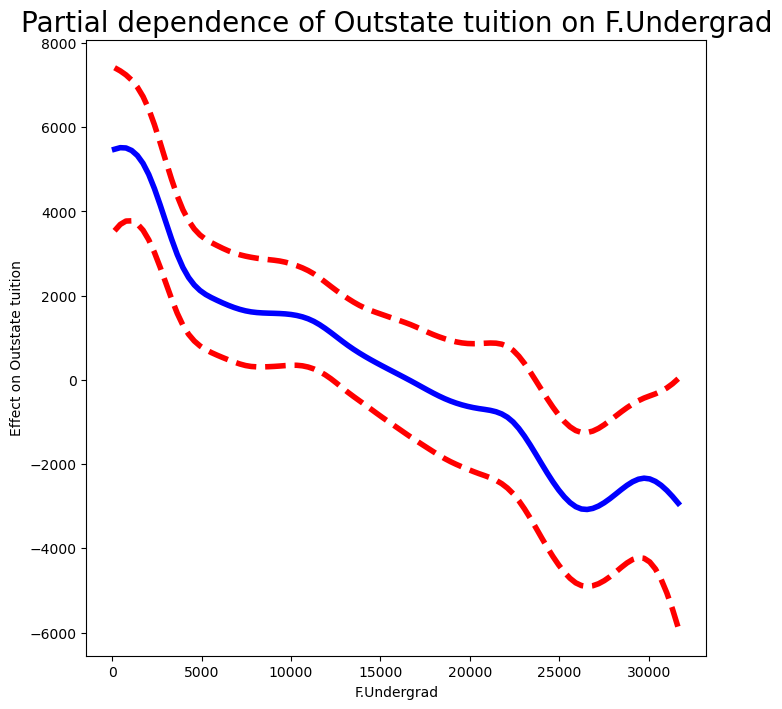

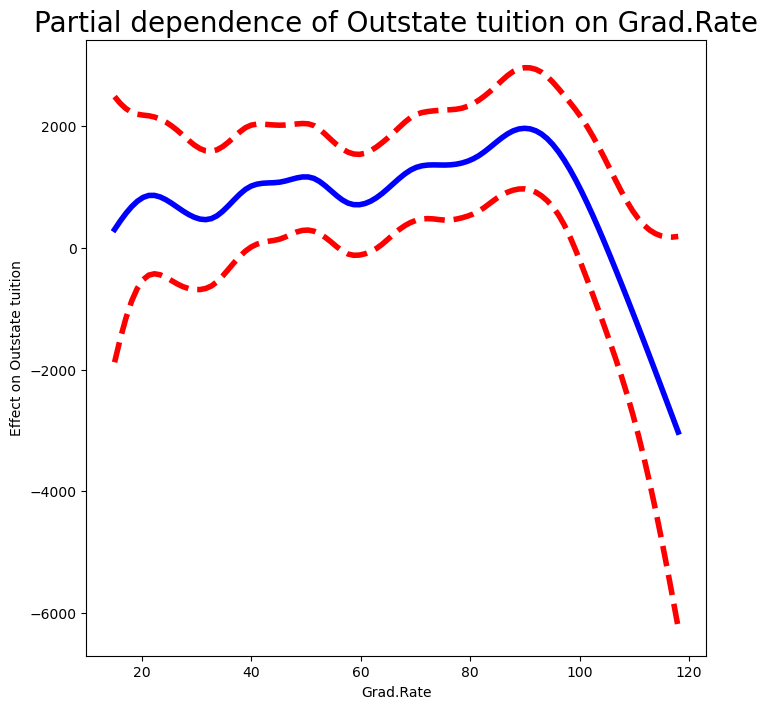

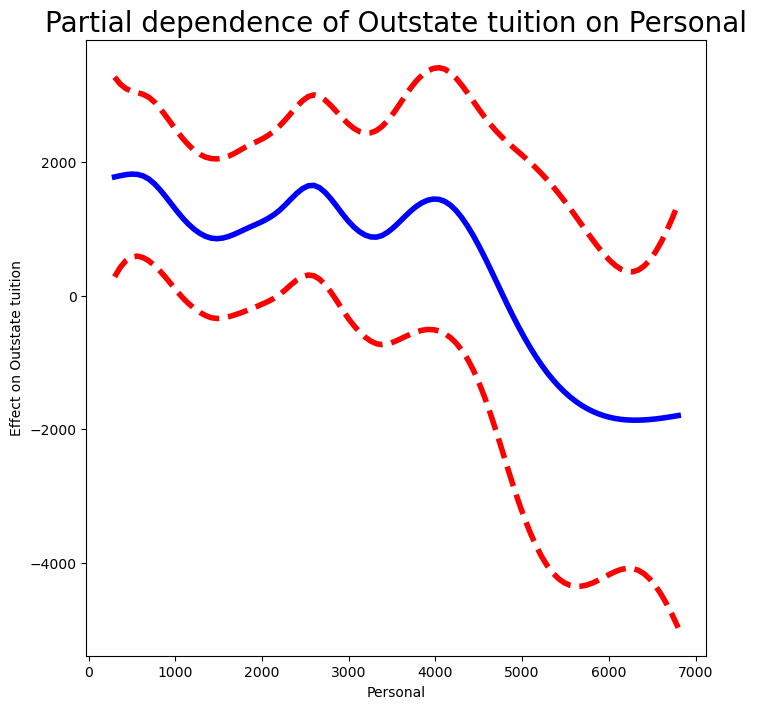

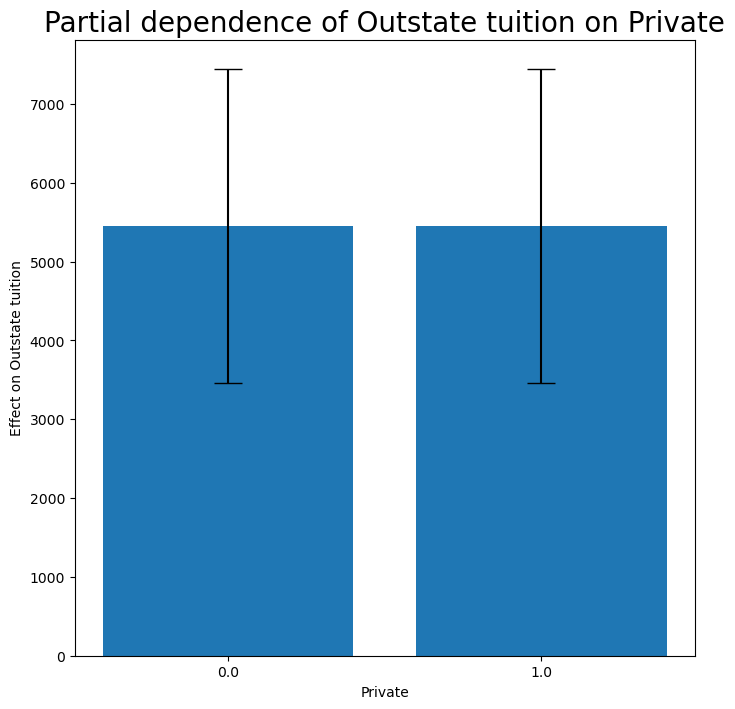

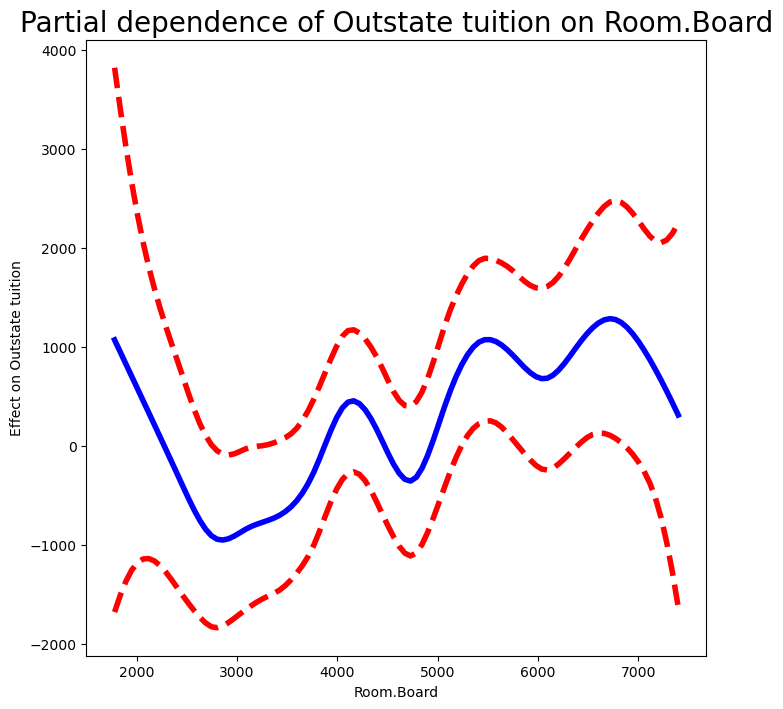

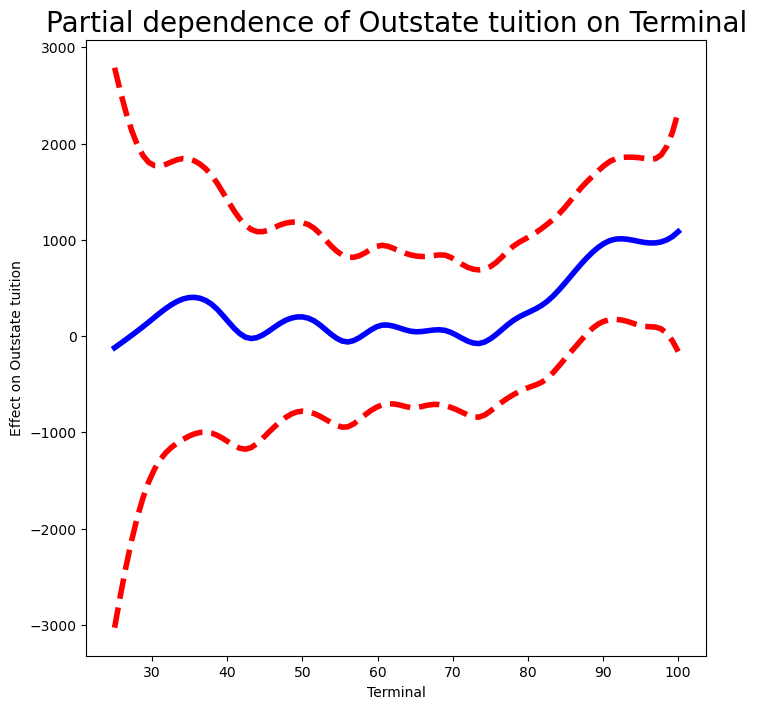

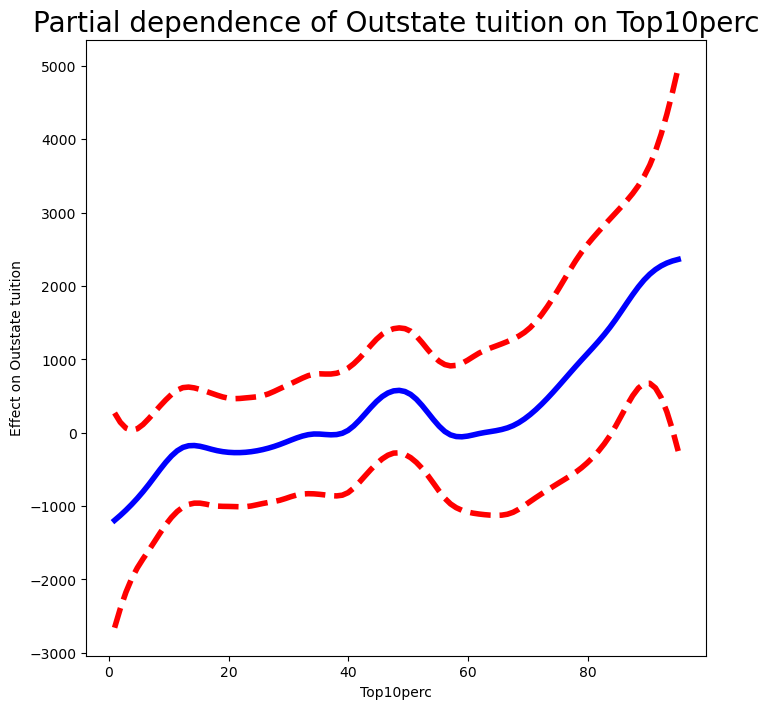

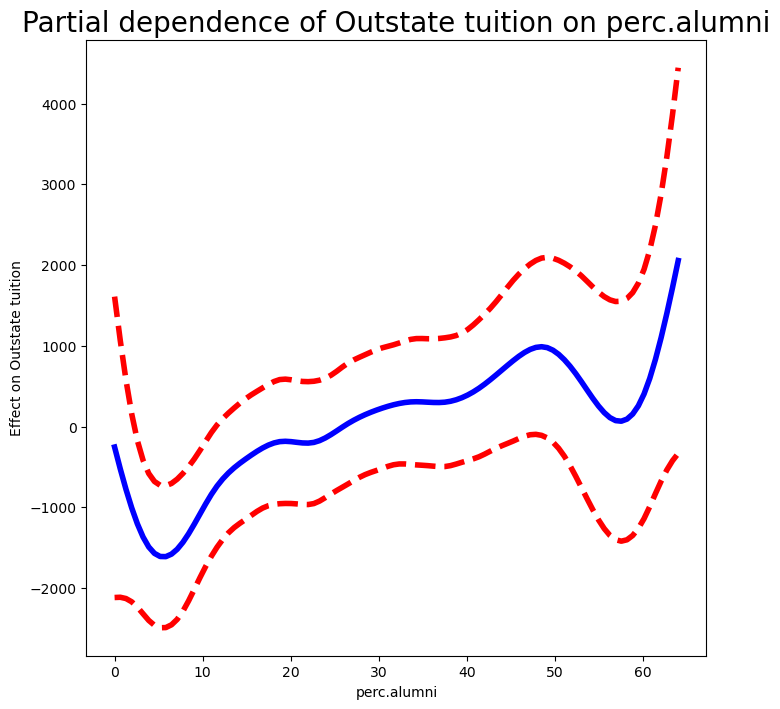

In [58]:
for d in Outstate_MSE.selected_state_:
    i=Outstate_MSE.selected_state_.index(d)
    fig, ax = subplots(figsize=(8, 8))
    ax = plot_gam(gam, i)
    ax.set_xlabel(d)
    ax.set_ylabel('Effect on Outstate tuition')
    ax.set_title('Partial dependence of Outstate tuition on '+d,fontsize=20);

Some of the graphs represented above display wiggly splines (e.g Outstate tuition on Terminal) which puts the gam model considered before into question.
In order to select the best GAM model we should consider the aformentionned cases and alternate between linear spline choices.
The comparison of obtained models can be done using ANOVA

We choose to experiment with the following features due the roughness of their splines shown on the previous graphs: 'perc.alumni', 'Room.Board' and 'Grad.Rate'.

In [59]:
gam2 = LinearGAM(s_gam(0)+ s_gam(1)+s_gam(2)+l_gam(3)+s_gam(4)+ f_gam(5, lam=0) 
                +l_gam(6)+s_gam(7)+s_gam(8)+l_gam(9))
gam2 = gam2.fit(Xgam, y)
anova_gam(gam2,gam)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,1.107500e+09,331.378505,NaN,NaN,NaN,NaN
1,9.835192e+08,304.809671,1.239812e+08,26.568834,1.446203,0.104873


The above table shows that 'gam' model is no better than the second. Hence gam2 is adopted for the rest of the exercise.

### (c)

In [60]:
y_test=College_valid['Outstate']
#vars_test=College_valid.columns.drop(['Outstate'])
#design_test=MS(vars_test).fit(College_valid)
#X_test=design.transform(College_valid)
X_test = np.column_stack([College_valid['Accept'],College_valid['Expend'],
                          College_valid['F.Undergrad'],College_valid['Grad.Rate'],
                        College_valid['Personal'], 
                          College_valid['Private'].cat.codes,College_valid['Room.Board'],
                        College_valid['Terminal'],College_valid['Top10perc'],
                          College_valid['perc.alumni']])

In [61]:
test_preds=gam2.predict(X_test)
r2_score(y_test,test_preds)

0.7978553110272971

The $R^2$ metric is nearly 80%, which is a sign of good  fit.

### (d)

In [62]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     83.1903
Link Function:                     IdentityLink Log Likelihood:                                 -6171.4888
Number of Samples:                          388 AIC:                                            12511.3582
                                                AICc:                                           12558.7292
                                                GCV:                                          5175682.4843
                                                Scale:                                        3226666.7927
                                                Pseudo R-Squared:                                   0.8459
Feature Function                  Lam

C:\Users\kabousselham\AppData\Local\Temp\ipykernel_17156\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [63]:
gam2.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     56.6215
Link Function:                     IdentityLink Log Likelihood:                                  -6185.127
Number of Samples:                          388 AIC:                                            12485.4969
                                                AICc:                                           12506.0074
                                                GCV:                                          4508356.3536
                                                Scale:                                        3342101.0886
                                                Pseudo R-Squared:                                   0.8265
Feature Function                  Lam

C:\Users\kabousselham\AppData\Local\Temp\ipykernel_17156\263715579.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam2.summary()


Using stepwise forward selection was a bad idea. The number of observations seem insufficient to bring stable results. Splitting the already small dataset made things worse (Steyerberg et al. show that there must be at least 50 observations per feature to have acceptable results using stepwise selection. See : Prognostic modeling with logistic regression analysis: in search of a sensible strategy in small data sets. ). pvalues don't reflect the correct values and hence are not reliable. In a more realistic case we should avoid stepwise selection and opt for other approaches for feature selection like ridge regression.

## Exercise 11

### (a)

In [86]:
n=100
np.random.seed(12)
X1=np.random.randn(n)
X2=np.random.randn(n)
epsilon=np.random.randn(n)
beta=[0.5,1,1.5]
Y=beta[0]+beta[1]*X1+beta[2]*X2+epsilon

### (b)

In [87]:
def simple_reg(outcome,feature):
    df=pd.DataFrame({'outcome':outcome,'feature':feature})
    design=MS(['feature'])
    X=design.fit_transform(df)
    model=sm.OLS(outcome,X)
    result=model.fit()
    return result.params[0],result.params[1]

### (c)

In [66]:
beta1=7

### (d)

In [92]:
beta0=simple_reg(Y-beta1*X1,X2)[0]
beta2=simple_reg(Y-beta1*X1,X2)[1]

array([0.41896491, 1.69607274])

### (e)

In [68]:
beta0=simple_reg(Y-beta2*X2,X1)[0]
beta1=simple_reg(Y-beta2*X2,X1)[1]

### (f)

For more accuracy we should rename betas found in both questions d and e by betahat in order to distinguish theme from real betas chosen in the beginning of the exercise

In [69]:
betahat=[beta0,beta1,beta2]
list_beta0=[betahat[0]]
list_beta1=[betahat[1]]
list_beta2=[betahat[2]]
for i in range(1000):
    list_beta2.append(simple_reg(Y-list_beta1[i]*X1,X2)[1])
    list_beta0.append(simple_reg(Y-list_beta2[i]*X2,X1)[0])
    list_beta1.append(simple_reg(Y-list_beta2[i]*X2,X1)[1])
betahat=[list_beta0[-1],list_beta1[-1],list_beta2[-1]]

In [70]:
betahat

[0.4047969576113644, 0.968847257111802, 1.6861064800144074]

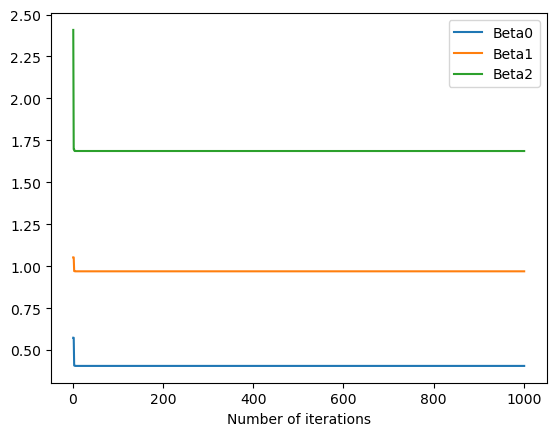

In [71]:
plt.plot(np.arange(1,1002),list_beta0,label = 'Beta0')
plt.plot(np.arange(1,1002),list_beta1,label = 'Beta1')
plt.plot(np.arange(1,1002),list_beta2,label = 'Beta2')
plt.legend()
plt.xlabel('Number of iterations');

### (g)

In [72]:
df=pd.DataFrame({'y':Y,'X1':X1,'X2':X2})
X = MS(['X1', 'X2']).fit_transform(df)
model = sm.OLS(Y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,0.4048,0.107,3.777,0.0
X1,0.9688,0.100,9.718,0.0
X2,1.6861,0.102,16.596,0.0


Both methods used in questions g and f yield the same results. As for Betahat, we notice that they are close to the real coefficients defined in question a.

### (h)

We can limlit the x axis of the previous graph to visualize after the number of iterations after which the coefficients converge.

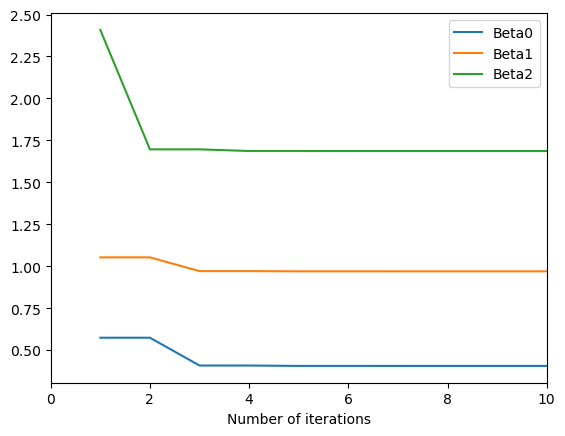

In [73]:
plt.plot(np.arange(1,1002),list_beta0,label = 'Beta0')
plt.plot(np.arange(1,1002),list_beta1,label = 'Beta1')
plt.plot(np.arange(1,1002),list_beta2,label = 'Beta2')
plt.legend()
plt.xlabel('Number of iterations')
plt.xlim(0,10);

After only 3 iterations, obtained results for the coefficients become stable.

## Exercise 12

In [181]:
np.random.seed(45)
X=np.random.rand(100,100)
c = np.random.randn(1)
beta=np.random.randn(100)
epsilon=np.random.randn(100)
Y=c+np.matmul(X,beta)+epsilon

In [182]:
lm= LinearRegression()
(Y).shape

(100,)

In [183]:
Xn=np.delete(X,1,1)
df=pd.DataFrame(X, columns = ['Column_'+str(i) for i in range(100)])

In [184]:
mul_beta_hat=np.zeros(100)#beta estimators obtained by multiple linear regression
design = MS(df).fit_transform(df)
result = sm.OLS(Y, design).fit()
for j in range(100):
    mul_beta_hat[j]=result.params[1:].values[j]

In [185]:
 mul_beta_hat.shape

(100,)

In [186]:
n_iter=100#number of iterations
mse=np.zeros(n_iter)#mean squared error of the backfitted linear regression
diff_mse=np.zeros(n_iter)#mean squared error among betas obtained by backfit and betas obtained by
#multiple linear regression
c_hat=np.zeros((n_iter,100))#intercept estimators obtained by backfit
beta_hat=np.zeros((n_iter,100))#beta estimators obtained by backfit
for j in range(n_iter):
    for i in range(100):
        beta_hat_i=np.delete(beta_hat[j,:],i,0)
        term=np.matmul(np.concatenate((X[:,:i], X[:,i+1:]), axis=1),beta_hat_i)
        c_hat[j:n_iter,i]=lm.fit(X[:,i].reshape(-1,1),Y-term).intercept_
        beta_hat[j:n_iter,i]=lm.fit(X[:,i].reshape(-1,1),Y-term).coef_[0]
    mse[j]=mean_squared_error(Y, c_hat[j,i]+np.matmul(X,beta_hat[j,:]))
    diff_mse[j]=mean_squared_error(mul_beta_hat,beta_hat[j,:])

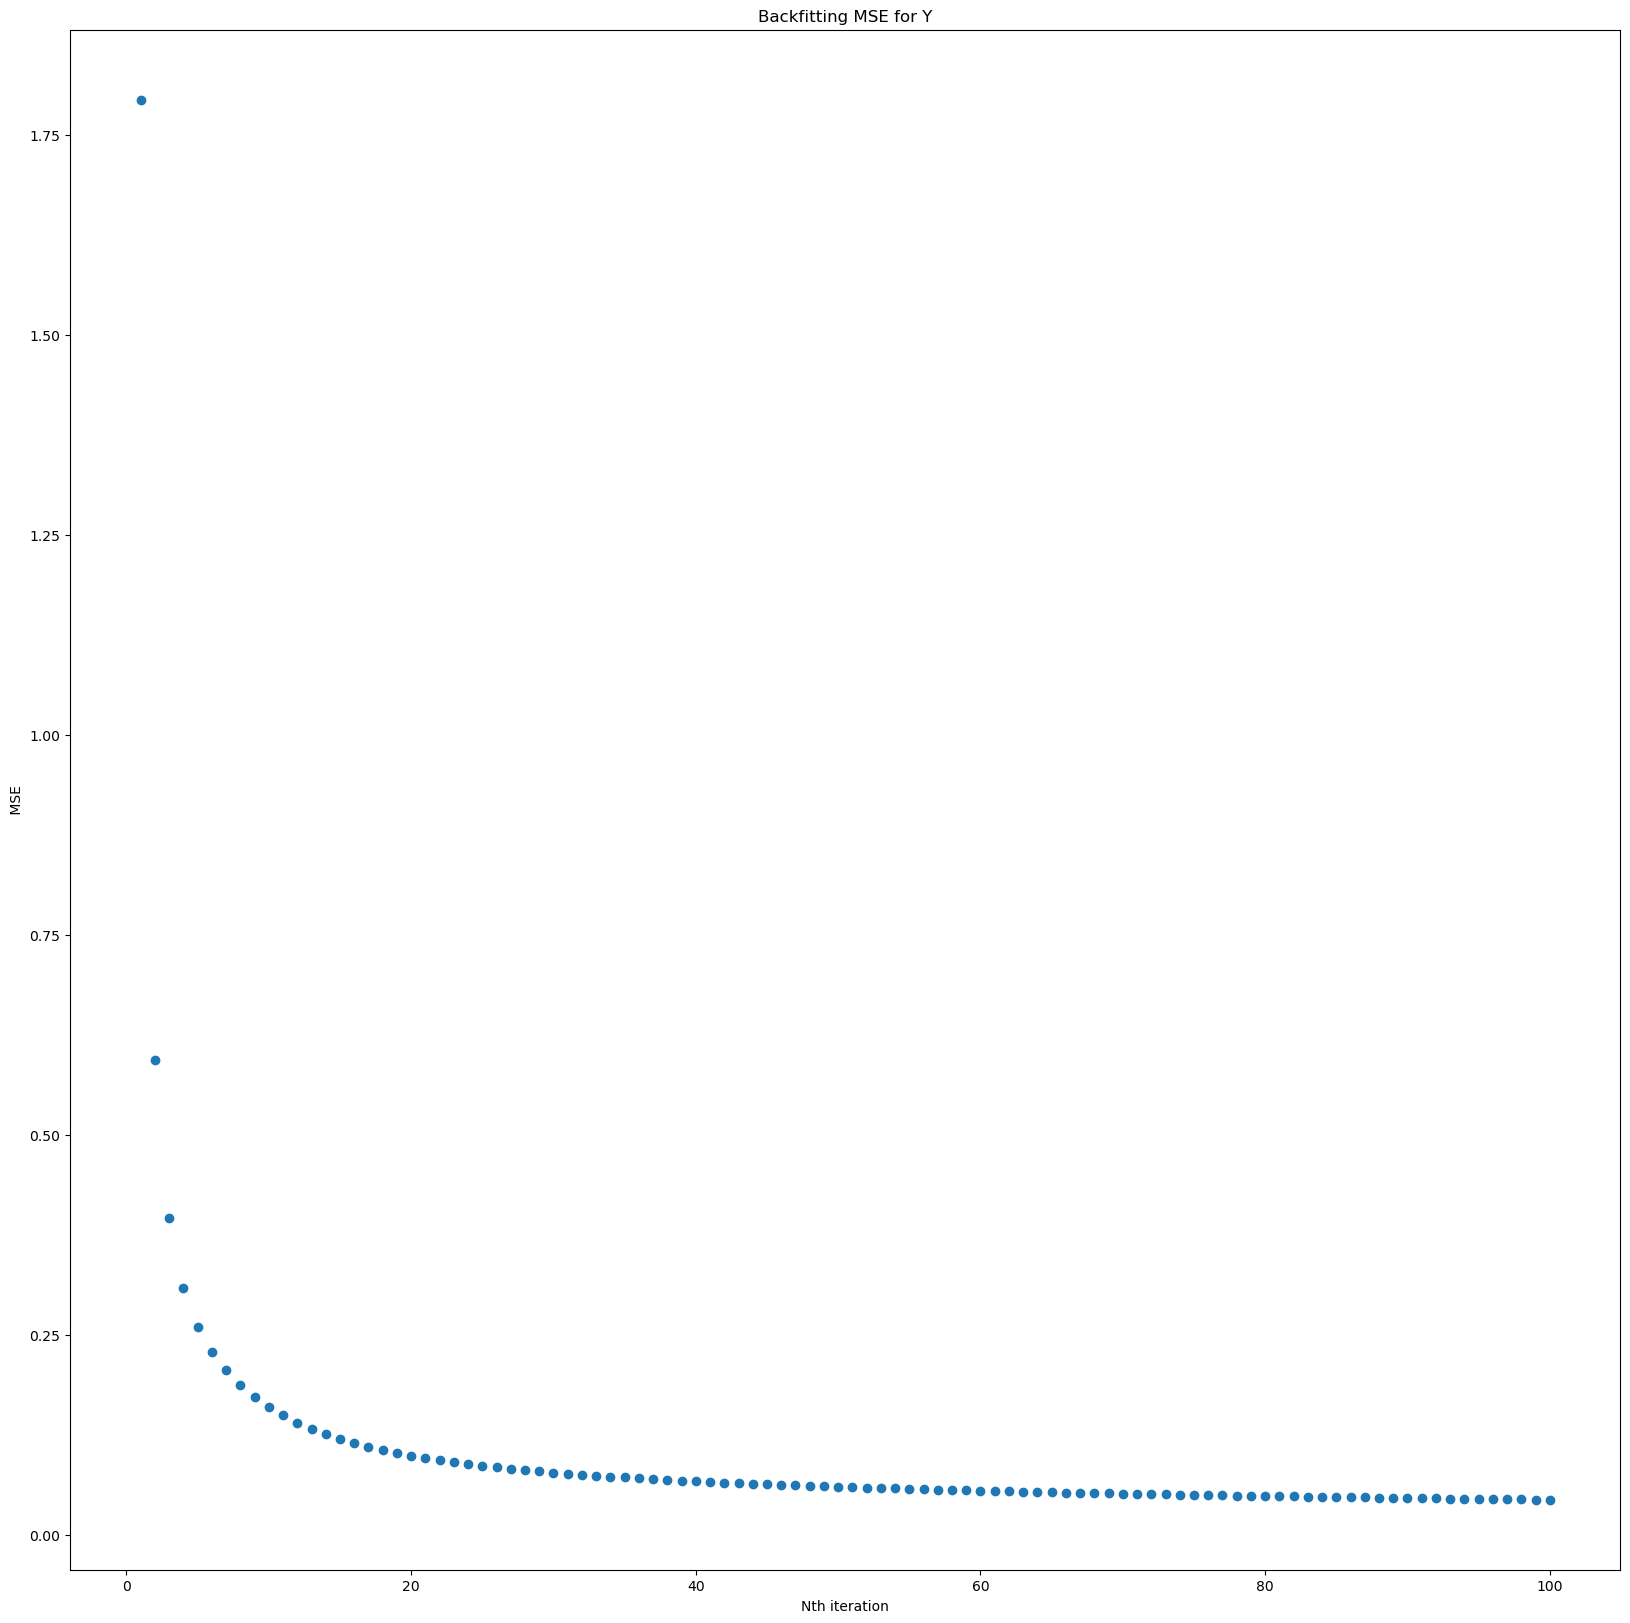

In [191]:
ax=subplots(figsize=(20,20))[1]
ax.scatter(range(1,n_iter+1), mse)
ax.set_xlabel('Nth iteration')
ax.set_title('Backfitting MSE for Y') 
ax.set_ylabel(' MSE ') ;

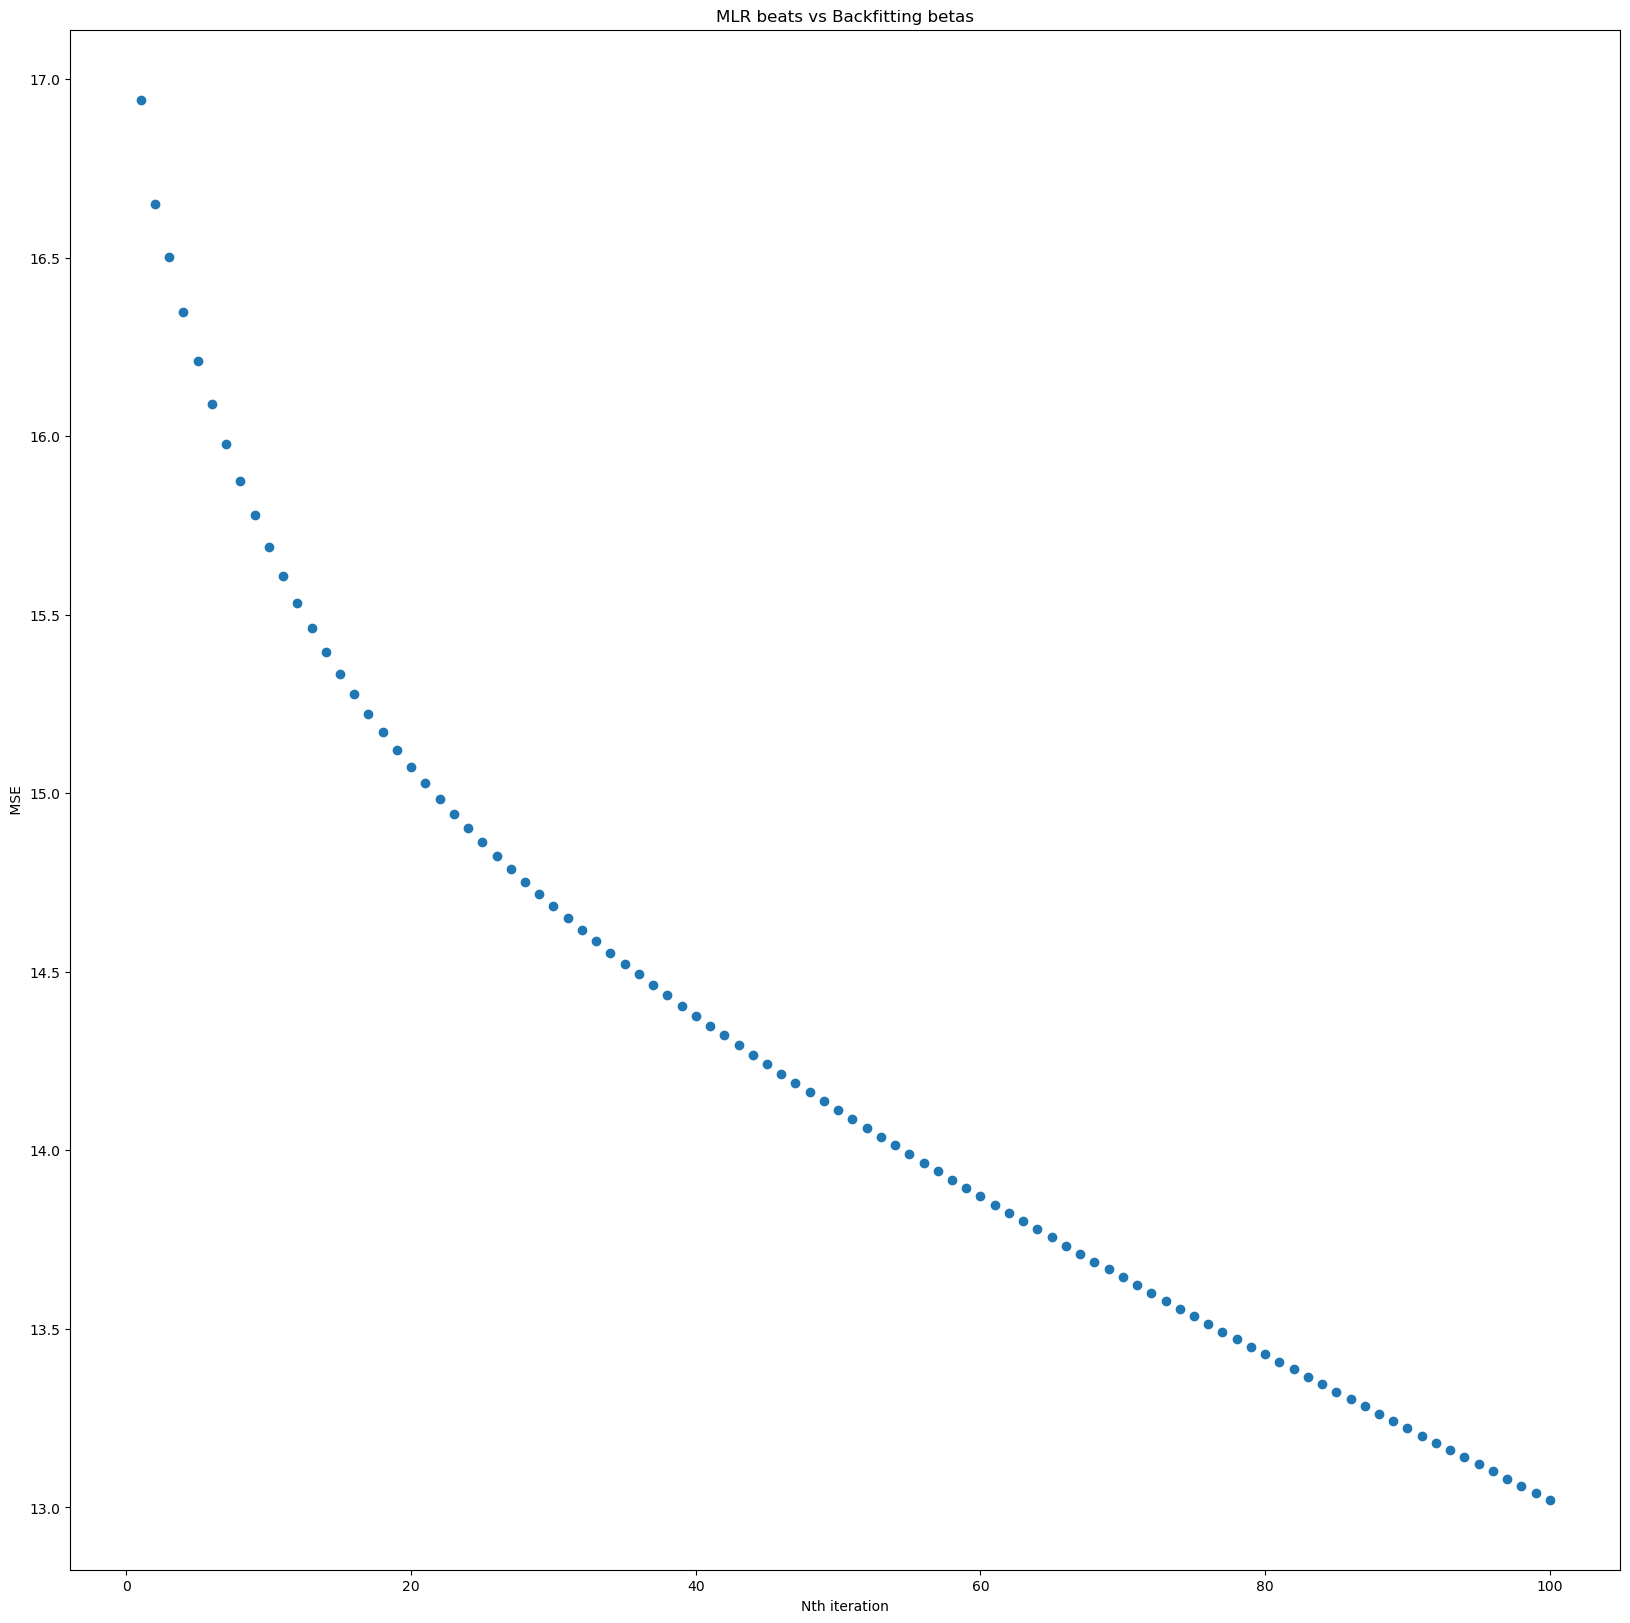

In [192]:
ax=subplots(figsize=(20,20))[1]
ax.scatter(range(1,n_iter+1), diff_mse)
ax.set_xlabel('Nth iteration')
ax.set_title('MLR beats vs Backfitting betas') 
ax.set_ylabel(' MSE ') ;

After 20 iterations mean square errors differences are with the last iteration are considered negligeable.